I will start off by performing data processing to analyze Olist's Brazilian ecommerce reviews and data. I will implement this by importing the required Python libraries and mounting my Google Drive to read my data files. These datasets include: customer review (1-5), customer info, order details, payment details, and seller info.

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import mannwhitneyu, ttest_ind
from google.colab import drive

from os.path import join

%matplotlib inline

# Mount Google Drive
drive.mount("/content/drive", force_remount=True)

# prefix used for file I/O
path_prefix = "/content/drive/My Drive/DSA210/Project/Brazil_ecommerce_dataset/"

# Define dtype specifications on import for problematic columns with mixed types
dtype_spec = {
    'product_name_lenght': 'float64',
    'product_description_lenght': 'float64',
    'product_photos_qty': 'float64',
    'product_weight_g': 'float64',
    'product_length_cm': 'float64',
    'product_height_cm': 'float64',
    'product_width_cm': 'float64',
    'customer_zip_code_prefix': 'int64',
    'seller_zip_code_prefix': 'int64'
}

# Read all data
brazil_indicators = pd.read_excel(join(path_prefix, "Brazil_world_bank_indicators.xls"))    # ENRICHING DATA
products_df = pd.read_csv(join(path_prefix, "olist_products_dataset.csv"))
sellers_df = pd.read_csv(join(path_prefix, "olist_sellers_dataset.csv"))
categoryName_df = pd.read_csv(join(path_prefix, "product_category_name_translation.csv"))
orderItems_df = pd.read_csv(join(path_prefix, "olist_order_items_dataset.csv"))
payments_df = pd.read_csv(join(path_prefix, "olist_order_payments_dataset.csv"))
reviews_df = pd.read_csv(join(path_prefix, "olist_order_reviews_dataset.csv"))
orders_df = pd.read_csv(join(path_prefix, "olist_orders_dataset.csv"))
customers_df = pd.read_csv(join(path_prefix, "olist_customers_dataset.csv"))
geolocation_df = pd.read_csv(join(path_prefix, "olist_geolocation_dataset.csv"))

# --- Merging Process ---
#processing geographic data
# Aggregate geo data by zip code prefix (first entry for each)
geo_agg = geolocation_df.groupby('geolocation_zip_code_prefix').first().reset_index()

# 1. Merge product category translations
products_merged = pd.merge(
    products_df,
    categoryName_df,
    on='product_category_name',
    how='inner'
).drop(columns=['product_category_name']).rename(
    columns={'product_category_name_english': 'product_category'}
)
# 2. Merge products and sellers with order items
order_items_merged = pd.merge(
    orderItems_df,
    products_merged,
    on='product_id',
    how='inner'
)
order_items_merged = pd.merge(
    order_items_merged,
    sellers_df,
    on='seller_id',
    how='inner'
)
# 3. Merge all order information
orders_merged = pd.merge(
    orders_df,
    order_items_merged,
    on='order_id',
    how='inner'
)
orders_merged = pd.merge(
    orders_merged,
    payments_df,
    on='order_id',
    how='inner'
)
orders_merged = pd.merge(
    orders_merged,
    reviews_df,
    on='order_id',
    how='inner'
)
# 4. Merge with customer data
data = pd.merge(
    orders_merged,
    customers_df,
    on='customer_id',
    how='inner'
)
# 5. Merge geographic data for customers
data = pd.merge(
    data,
    geo_agg,
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='inner',
    suffixes=('', '_customer')
)
# 6. Merge geographic data for sellers
data = pd.merge(
    data,
    geo_agg,
    left_on='seller_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='inner',
    suffixes=('', '_seller')
)
data = pd.concat([data, brazil_indicators], axis=1) #Concatenation of enriching data
# change column names for readability
data = data.rename(columns={
    'geolocation_lat': 'customer_latitude',
    'geolocation_lng': 'customer_longitude',
    'geolocation_lat_seller': 'seller_latitude',
    'geolocation_lng_seller': 'seller_longitude'
})

Mounted at /content/drive


#Studying My Dataset

 In order to decide the next step, I will verify the merginng and investigate my dataset by showing:
   

*   The **shape** of the dataframe
*   The **type** of each **column**

*   The **head** of the data


*   The **dicriptive statistics** for teh numerical data




In [60]:
print(f"\nMerged DataFrame: {data.shape}")
print("\nMerged DataFrame head:")
print(data.head())


Merged DataFrame: (115037, 104)

Merged DataFrame head:
                           order_id                       customer_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  3ce436f183e68e07877b285a838db11a   
1  00018f77f2f0320c557190d7a144bdd3  f6dd3ec061db4e3987629fe6b26e5cce   
2  000229ec398224ef6ca0657da4fc703e  6489ae5e4333f3693df5ad4372dab6d3   
3  00024acbcdf0a6daa1e931b038114c75  d4eb9395c8c0431ee92fce09860c5a06   
4  00042b26cf59d7ce69dfabb4e55b4fd9  58dbd0b2d70206bf40e62cd34e84d795   

  order_status order_purchase_timestamp order_approved_at  \
0    delivered           9/13/2017 8:59    9/13/2017 9:45   
1    delivered          4/26/2017 10:53   4/26/2017 11:05   
2    delivered          1/14/2018 14:33   1/14/2018 14:48   
3    delivered           8/8/2018 10:00    8/8/2018 10:10   
4    delivered           2/4/2017 13:57    2/4/2017 14:10   

  order_delivered_carrier_date order_delivered_customer_date  \
0              9/19/2017 18:34               9/20/2017 23:43   
1        

In [61]:
print("\nColumn datatypes:")
print(data.dtypes)


Column datatypes:
order_id                     object
customer_id                  object
order_status                 object
order_purchase_timestamp     object
order_approved_at            object
                             ...   
2018                        float64
2019                        float64
2020                        float64
2021                        float64
2022                        float64
Length: 104, dtype: object


In [62]:
print("\nDescriptive statistics for numerical columns:")
print(data.describe())


Descriptive statistics for numerical columns:
       Unnamed: 8_x  Unnamed: 9  Unnamed: 10_x  Unnamed: 11_x  Unnamed: 12_x  \
count           0.0         0.0            0.0            0.0            0.0   
mean            NaN         NaN            NaN            NaN            NaN   
std             NaN         NaN            NaN            NaN            NaN   
min             NaN         NaN            NaN            NaN            NaN   
25%             NaN         NaN            NaN            NaN            NaN   
50%             NaN         NaN            NaN            NaN            NaN   
75%             NaN         NaN            NaN            NaN            NaN   
max             NaN         NaN            NaN            NaN            NaN   

       Unnamed: 13_x  Unnamed: 14_x  Unnamed: 16_x  Unnamed: 17  Unnamed: 18  \
count            0.0     247.000000     247.000000   247.000000   247.000000   
mean             NaN       1.032389       2.813765   159.553684     1.13

# Data Processing

# Date Columns Conversion, Creating New Time Feature Columns, and Sorting


*  By observing the previous code block, I will **convert** the data type of the following columns from object **to dateime:** estimated delivery time, actual delivery time, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date.

-

* Creating meaningful data by calculating **new columns**: **actual delivery duration** and **delivery delay** by subtracting the values in estimated delivery time column from the actual delivery time column.

-


* **Sort** Data with respect to the **order_purchase_timestamp** column, to get orders in chronological sequence , which is the most useful view for e-commerce analysis, such as: Time series analysis, understanding sales trends, and maintaining transaction chronology



In [63]:
# Data Cleaning
# Convert all date columns to datetime objects
date_columns = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'shipping_limit_date',
    'review_creation_date',
    'review_answer_timestamp'
]
for col in date_columns:
    if col in data.columns:
        data[col] = pd.to_datetime(data[col], errors='coerce')

# Verify datetime conversion
print("\nDate columns after conversion:")
print(data.dtypes)

# Calculate time-based features
data['purchase_to_delivery_days'] = (
    (data['order_delivered_customer_date'] - data['order_purchase_timestamp']).dt.days
)
data['delivery_delay_days'] = (
    (data['order_delivered_customer_date'] - data['order_estimated_delivery_date']).dt.days
)
data['review_response_time_days'] = (
    (data['review_answer_timestamp'] - data['review_creation_date']).dt.days
)

#Sort by order purchase timestamp
data = data.sort_values('order_purchase_timestamp', ascending=True)

# Display conversion and sorted data to verify sort
print(f"\nDate range: {data['order_purchase_timestamp'].min()} to {data['order_purchase_timestamp'].max()}")
print(f"Data shape: {data.shape}")
data.head()


Date columns after conversion:
order_id                            object
customer_id                         object
order_status                        object
order_purchase_timestamp    datetime64[ns]
order_approved_at           datetime64[ns]
                                 ...      
2018                               float64
2019                               float64
2020                               float64
2021                               float64
2022                               float64
Length: 104, dtype: object

Date range: 2016-09-04 21:15:00 to 2018-09-03 09:06:00
Data shape: (115037, 107)


order_id                       customer_id  \
20736   2e7a8482f6fb09756ca50c10d7bfc047  08c5351a6aca1c1589a38f244edeee9d   
20737   2e7a8482f6fb09756ca50c10d7bfc047  08c5351a6aca1c1589a38f244edeee9d   
103531  e5fa5a7210941f7d56d0208e4e071d35  683c54fc24d40ee9f8a6fc179fd9856c   
51076   71303d7e93b399f5bcd537d124c0bcfa  b106b360fe2ef8849fbbd056f777b4d5   
26738   3b697a20d9e427646d92567910af6d57  355077684019f7f60a031656bd7262b8   

       order_status order_purchase_timestamp   order_approved_at  \
20736       shipped      2016-09-04 21:15:00 2016-10-07 13:18:00   
20737       shipped      2016-09-04 21:15:00 2016-10-07 13:18:00   
103531     canceled      2016-09-05 00:15:00 2016-10-07 13:17:00   
51076      canceled      2016-10-02 22:07:00 2016-10-06 15:50:00   
26738     delivered      2016-10-03 09:44:00 2016-10-06 15:50:00   

       order_delivered_carrier_date order_delivered_customer_date  \
20736           2016-10-18 13:14:00                           NaT   
20737           2016-10-18 13:14:00                           NaT   
103531                          NaT                           NaT   
51076                           NaT                           NaT   
26738           2016-10-23 14:02:00           2016-10-26 14:02:00   

       order_estimated_delivery_date  Unnamed: 8_x  Unnamed: 9  ...  2016  \
20736                     2016-10-20           NaN         NaN  ...   NaN   
20737                     2016-10-20           NaN         NaN  ...   NaN   
103531                    2016-10-28           NaN         NaN  ...   NaN   
51076                     2016-10-25           NaN         NaN  ...   NaN   
26738                     2016-10-27           NaN         NaN  ...   NaN   

        2017  2018  2019  2020 2021  2022  purchase_to_delivery_days  \
20736    NaN   NaN   NaN   NaN  NaN   NaN                        NaN   
20737    NaN   NaN   NaN   NaN  NaN   NaN                        NaN   
103531   NaN   NaN   NaN   NaN  NaN   NaN                        NaN   
51076    NaN   NaN   NaN   NaN  NaN   NaN                        NaN   
26738    NaN   NaN   NaN   NaN  NaN   NaN                       23.0   

        delivery_delay_days review_response_time_days  
20736                   NaN                        24  
20737                   NaN                        24  
103531                  NaN                         1  
51076                   NaN                         0  
26738                  -1.0                         4  

[5 rows x 107 columns]

# Missing Values (NaN Values)


I will Check the NaN values and print the percentages per column to identify which columns have missing values.


In [64]:
#Data Cleaning
#check for NaN values and calculate percentages
nan_percentage = data.isnull().sum() / len(data) * 100

# Print columns with NaN values and their percentages
print("\nPercentage of NaN values per column:")
print(nan_percentage[nan_percentage > 0])


Percentage of NaN values per column:
order_approved_at                  0.012170
order_delivered_carrier_date       1.030103
order_delivered_customer_date      2.072377
Unnamed: 8_x                     100.000000
Unnamed: 9                       100.000000
                                    ...    
2020                              99.148100
2021                              99.162878
2022                              99.238506
purchase_to_delivery_days          2.072377
delivery_delay_days                2.072377
Length: 66, dtype: float64


# Dealing with the NaN
Since there are several unnamed columns with very high NaN percetage (100%), I will drop those columns with a threshold of 50% NaN.

In [65]:
# Identify columns with a high percentage of NaN values with a threshold of 70%
high_nan_columns = nan_percentage[nan_percentage > 50].index
print(f"\nColumns identified for potential dropping due to >50% NaN values: {list(high_nan_columns)}")

# Drop the identified columns from the DataFrame and then display the shape of the dataset
data = data.drop(columns=high_nan_columns)
print(f"\nDataFrame shape after dropping high NaN columns: {data.shape}")

# Verify missing values in the new DataFrame
missing_percent_after_dropping_cols = (data.isnull().sum() / len(data)) * 100

print("\nMissing values after dropping high NaN percentage columns:")
# Only print columns that still have missing values
cols_with_nan_after_col_drop = missing_percent_after_dropping_cols[missing_percent_after_dropping_cols > 0].index
if len(cols_with_nan_after_col_drop) > 0:
    for col in cols_with_nan_after_col_drop:
        print(f"{col}: ({missing_percent_after_dropping_cols[col]:.5f}%)")
else:
    print("No missing values remaining in the selected columns.")



Columns identified for potential dropping due to >50% NaN values: ['Unnamed: 8_x', 'Unnamed: 9', 'Unnamed: 10_x', 'Unnamed: 11_x', 'Unnamed: 12_x', 'Unnamed: 13_x', 'Unnamed: 14_x', 'Unnamed: 15_x', 'Unnamed: 16_x', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 7_x', 'Unnamed: 8_y', 'Unnamed: 9_x', 'Unnamed: 10_y', 'Unnamed: 11_y', 'Unnamed: 12_y', 'Unnamed: 13_y', 'Unnamed: 14_y', 'Unnamed: 15_y', 'Unnamed: 16_y', 'Unnamed: 9_y', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'review_comment_title', 'review_comment_message', 'Unnamed: 7_y', 'Unnamed: 1', 'Unnamed: 6', 'Unnamed: 5', 'Unnamed: 6_customer', 'Unnamed: 5_seller', 'Unnamed: 6_seller', 'Indicator Name', 'Indicator Code', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']

DataFrame shape after dropping high NaN columns: (115037, 50)

Missing values after dro

In [66]:
# used AI, prompt: fix the error ipython-input-7-e6158c683f32>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
# The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

# Identify columns that still have missing values
cols_with_nan = data.columns[data.isnull().any()].tolist()

print(f"\nColumns with remaining NaN values: {cols_with_nan}")

for col in cols_with_nan:
    if data[col].dtype in ['float64', 'int64']:
        # For numerical columns, fill NaN with the mean
        data[col] = data[col].fillna(data[col].mean())
    elif data[col].dtype == 'object':
        # For object/categorical columns, fill NaN with the mode
        # Check if mode exists before filling
        if not data[col].mode().empty:
            data[col] = data[col].fillna(data[col].mode()[0])
        else:
            print(f"Column '{col}' is object type with NaN values and no mode. Consider dropping or another filling strategy.")
    elif data[col].dtype == 'datetime64[ns]':
        # for datetime columns I will use forward fill
        data[col] = data[col].ffill()
    else:
        # Handle other potential data types if necessary
        print(f"Column '{col}' has an unhandled dtype '{data[col].dtype}' with NaN values.")

# Final check for missing values
missing_percent_final = (data.isnull().sum() / len(data)) * 100
print("\nFinal check for missing values:")
cols_with_nan_final = missing_percent_final[missing_percent_final > 0].index

if len(cols_with_nan_final) > 0:
    for col in cols_with_nan_final:
        print(f"{col}: ({missing_percent_final[col]:.2f}%)")
else:
    print("No missing values remaining in the DataFrame.")

print(f"\nFinal DataFrame shape after dealing with remaining NaNs: {data.shape}")



Columns with remaining NaN values: ['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'purchase_to_delivery_days', 'delivery_delay_days']

Final check for missing values:
order_delivered_customer_date: (0.00%)

Final DataFrame shape after dealing with remaining NaNs: (115037, 50)


Saving the clean, merged and processed data into an excel sheet

In [67]:
output_excel = join(path_prefix, "brazilian_ecommerce_merged.xlsx")
print(f"Saving cleaned and merged data to Excel file: {output_excel}")
with pd.ExcelWriter(output_excel, engine='openpyxl') as writer:
    data.to_excel(writer, index=False, sheet_name='Merged Data')

print(data.head(2))

Saving cleaned and merged data to Excel file: /content/drive/My Drive/DSA210/Project/Brazil_ecommerce_dataset/brazilian_ecommerce_merged.xlsx
                               order_id                       customer_id  \
20736  2e7a8482f6fb09756ca50c10d7bfc047  08c5351a6aca1c1589a38f244edeee9d   
20737  2e7a8482f6fb09756ca50c10d7bfc047  08c5351a6aca1c1589a38f244edeee9d   

      order_status order_purchase_timestamp   order_approved_at  \
20736      shipped      2016-09-04 21:15:00 2016-10-07 13:18:00   
20737      shipped      2016-09-04 21:15:00 2016-10-07 13:18:00   

      order_delivered_carrier_date order_delivered_customer_date  \
20736          2016-10-18 13:14:00                           NaT   
20737          2016-10-18 13:14:00                           NaT   

      order_estimated_delivery_date  order_item_id  \
20736                    2016-10-20              1   
20737                    2016-10-20              2   

                             product_id  ... geolocation

# Visualization

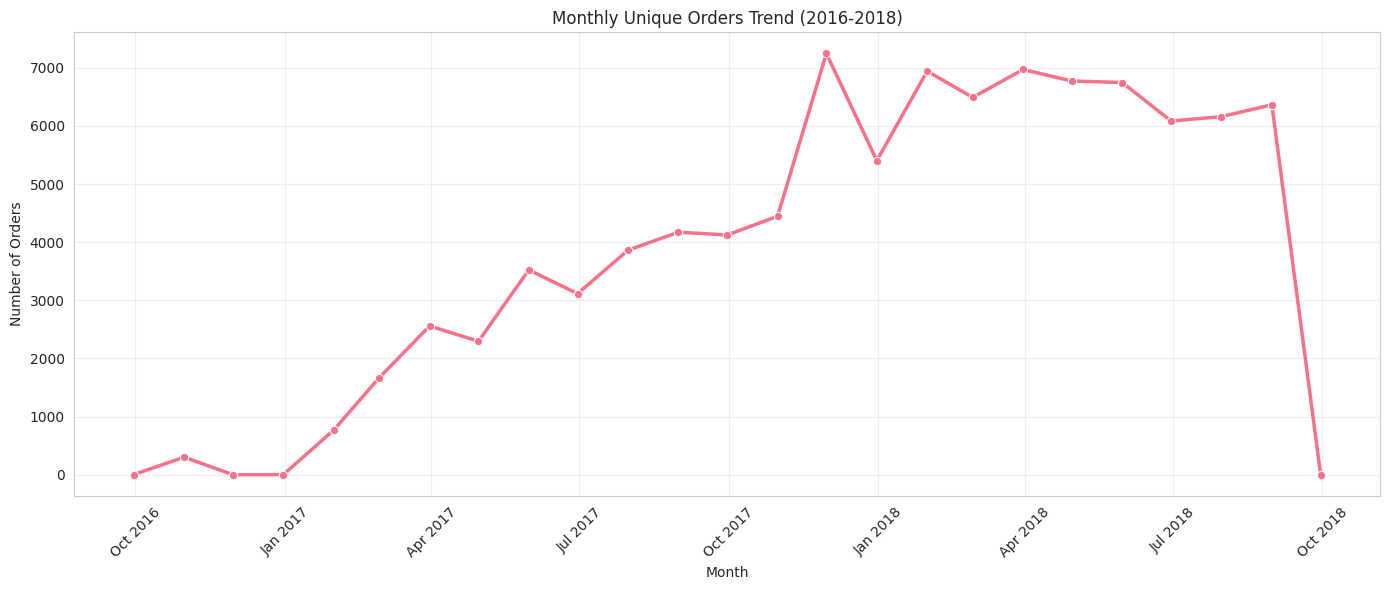

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

# Set visual style
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = 'white'

# 1. SALES TREND ANALYSIS (YEAR-MONTH)
plt.figure(figsize=(14, 6))
monthly_orders = data.set_index('order_purchase_timestamp').resample('M')['order_id'].nunique()
ax = sns.lineplot(data=monthly_orders, marker='o', linewidth=2.5)
ax.set(title='Monthly Unique Orders Trend (2016-2018)',
       ylabel='Number of Orders',
       xlabel='Month')
ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

This time series graph for the order purchase time per month and the number of unique orders shows a **growth trend in the order volume from 2016 to 2018,** this can be explained by the Brazilian Economy's reviving ecommerce after the 2016 economic recession and seasonal spikes later on. This exemplifies teh business life cycle of Olist.

However, there is a sudden sharp fall in the number of orders at the end of 2018. This suggests market maturation, competitive pressure, or perhaps incomplete data.

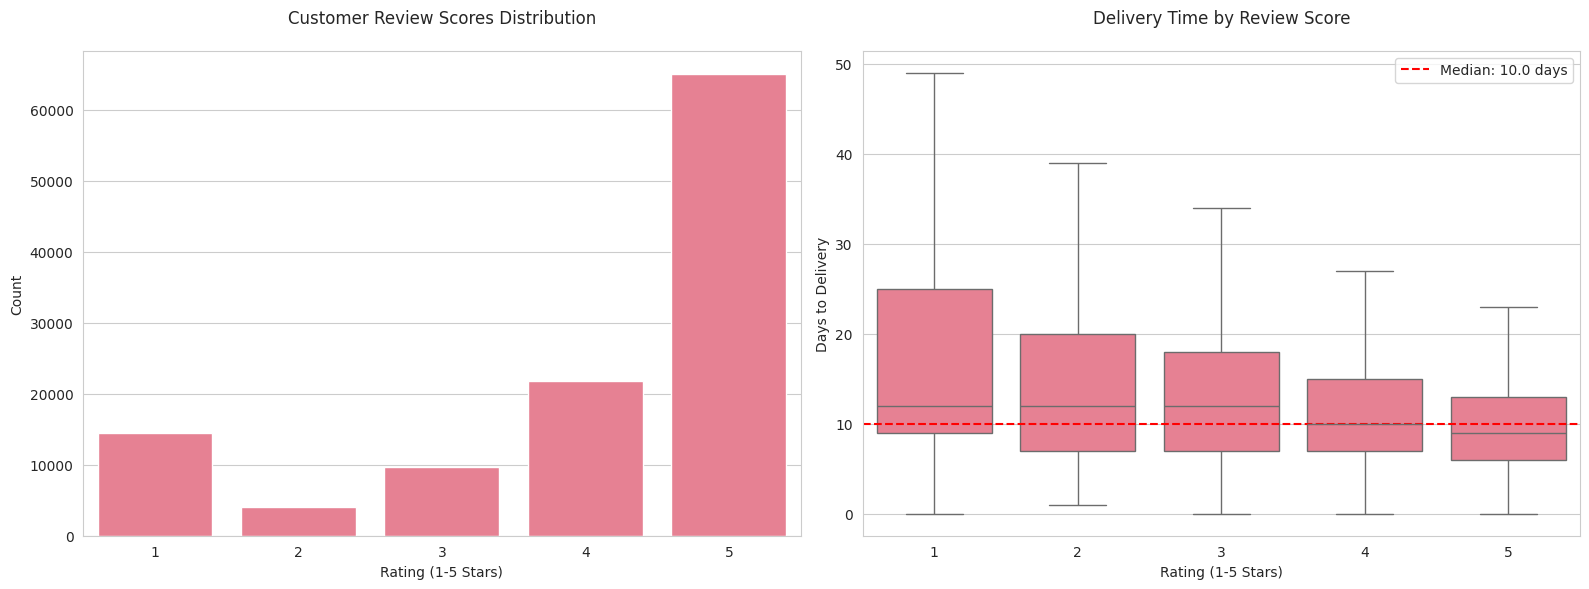

In [69]:
# 2. CUSTOMER SATISFACTION DASHBOARD
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Review Score Distribution
sns.countplot(data=data, x='review_score', ax=ax1,
              order=sorted(data['review_score'].dropna().unique()))
ax1.set_title('Customer Review Scores Distribution', pad=20)
ax1.set_xlabel('Rating (1-5 Stars)')
ax1.set_ylabel('Count')

# Review Score vs Delivery Time
sns.boxplot(data=data, x='review_score', y='purchase_to_delivery_days',
            ax=ax2, showfliers=False)
ax2.set_title('Delivery Time by Review Score', pad=20)
ax2.set_xlabel('Rating (1-5 Stars)')
ax2.set_ylabel('Days to Delivery')
ax2.axhline(y=data['purchase_to_delivery_days'].median(),
            color='red', linestyle='--',
            label=f'Median: {data["purchase_to_delivery_days"].median():.1f} days')
ax2.legend()

plt.tight_layout()
plt.show()

The bar graph on the left of the review scores (ranging from 1 to 5) with the count of the count of reviews for each score, shows the distribution of the cutomer reviews. It is clear that 5  was the most given seleted review score.


The box plot of the delivery time by the review score reveals **a strong negative correlation between delivery time and satisfaction of customers**.


 For instnace, the 1-star reviews experienced ~25 days delivery vs ~15 days for 5-star reviews. so can say that faster deliveries correlate to better customer satisfaction.


 The dashed line represents the overall median delivery time (~10 days) regardless of the review scores. I used this as a baseline to analyze whether certain raitings had faster or slower than average delivery.


 5 score reviews are below the line, indicating they had the fastest delivery time overall, which proves the previous correlation.


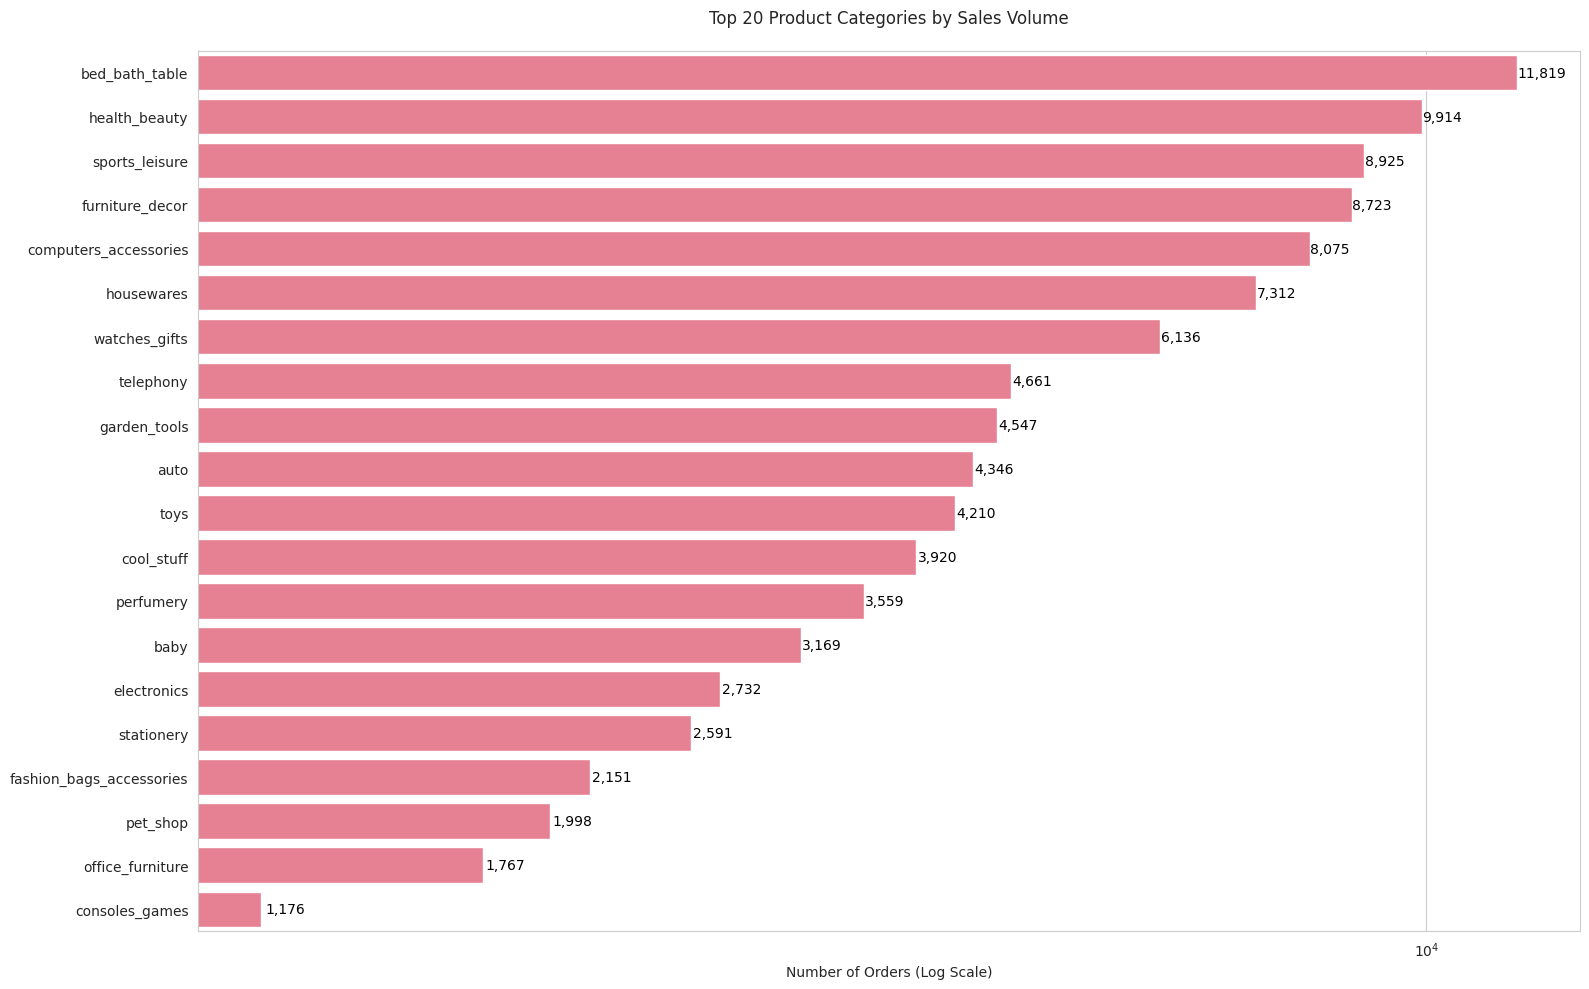

In [70]:
# 3. PRODUCT CATEGORY ANALYSIS
plt.figure(figsize=(16, 10))
top_cats = data['product_category'].value_counts().nlargest(20)
sns.barplot(y=top_cats.index, x=top_cats.values, orient='h')
plt.title('Top 20 Product Categories by Sales Volume', pad=20)
plt.xlabel('Number of Orders (Log Scale)')
plt.xscale('log')
plt.ylabel('')

# Add value labels
for i, v in enumerate(top_cats.values):
    plt.text(v+10, i, f"{v:,}", color='black', va='center')

plt.tight_layout()
plt.show()

I implemented a horizontal bar chart with logarithmic scale (to make the difference appear smaller than they are) for the number of orders and the product categories. The logarithmic scale reveals disporpotionately high sales concentration for bed/bath/table products leading at ~12,000 orders, followed by health/beauty (~10,000) and sports/leisure (~9,000). whereas, categories from electronics downward have much less sales volume. The domination of the home categories suggests that Olist serves practical household needs more than luxury or specialty items.


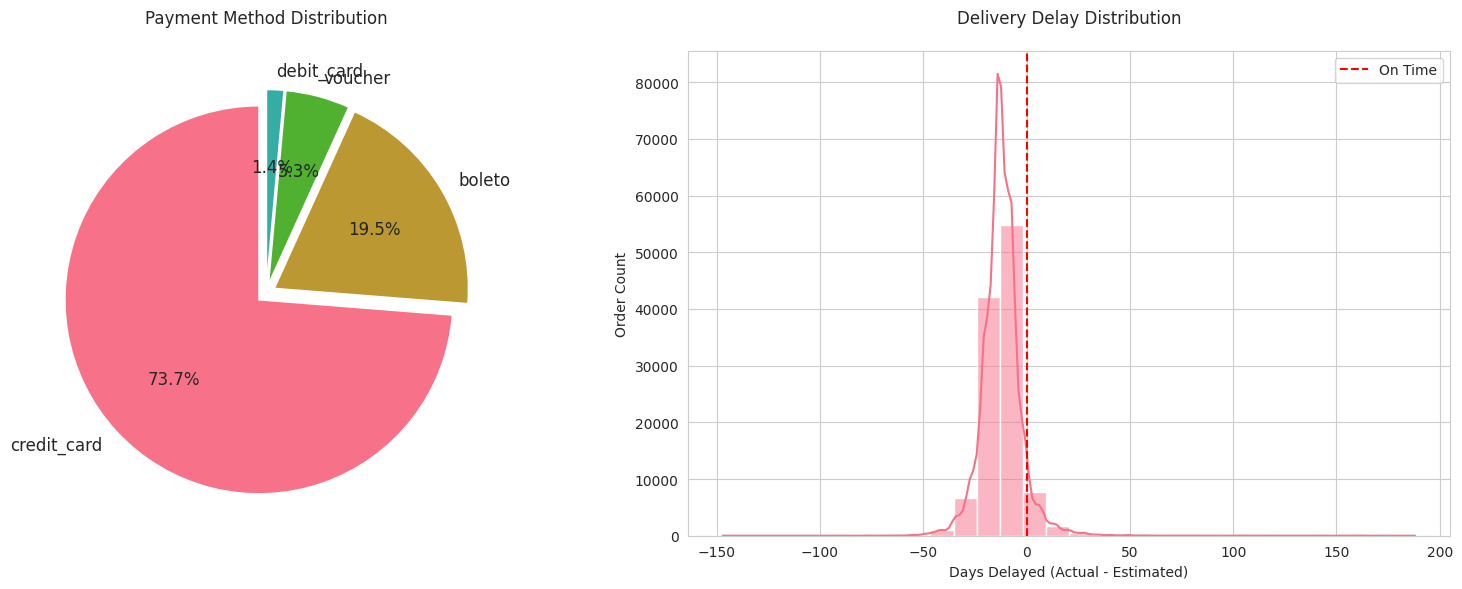

In [71]:
# 4. PAYMENT & DELIVERY ANALYSIS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Payment Methods
payment_data = data['payment_type'].value_counts()
ax1.pie(payment_data, labels=payment_data.index,
        autopct='%1.1f%%', startangle=90,
        explode=[0.05]*len(payment_data),
        textprops={'fontsize': 12})
ax1.set_title('Payment Method Distribution', pad=20)

# Delivery Performance
sns.histplot(data=data, x='delivery_delay_days', bins=30,
             kde=True, ax=ax2)
ax2.set_title('Delivery Delay Distribution', pad=20)
ax2.set_xlabel('Days Delayed (Actual - Estimated)')
ax2.set_ylabel('Order Count')
ax2.axvline(x=0, color='red', linestyle='--', label='On Time')
ax2.legend()

plt.tight_layout()
plt.show()

The left plot is a pie chart of the paymenty method percentages and order count. The chart shows an overwhelming **preference for credit cards (73.7%)** over alternative payments like boleto (19.5%).


The Histogram with normal distribution overlay on the right, grapahs the number of delayed delivery Days (esitmated - actual) with the order count. It reveals Olist's great logistics performance given the narrow normal distribution centered slightly left of zero, with the peak around -5 (early) to 0 days. **This highlisghts the relaibility of Olist's delivery, and as indicated by the center mean, most deliveries are early.**



The red dashed line at 0 days represents the "On Time" delivery benchmark. This serves as a critical reference point that divides the distribution into two meaningful zones: deliveries that arrived early (left of the line, negative values) and deliveries that were delayed (right of the line, positive values). hence, immediately we notice that majority of order deliveries (approximately 60-70%) are ealry or on time and the remaining are late just by looking at the histogram. This is useful for monitoring and assessing performance with customer satisfaction metrics.

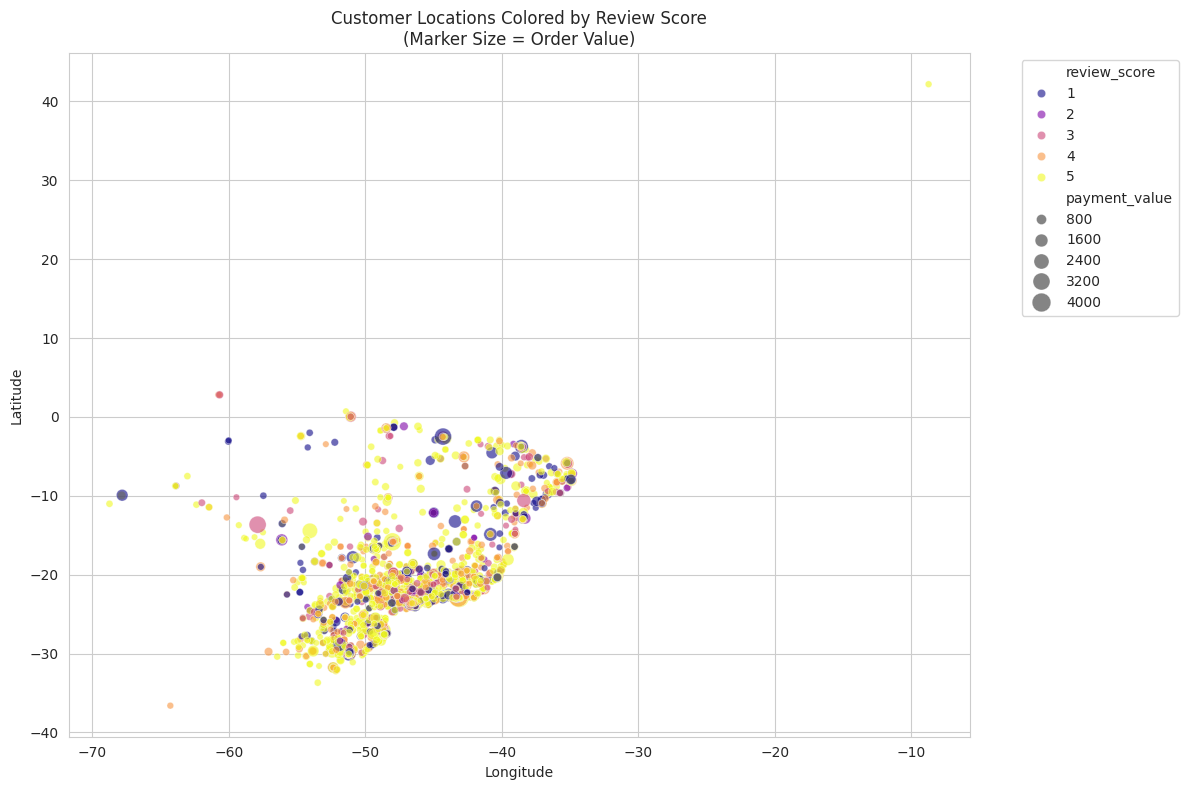

In [72]:
# 5. CUSTOMER GEOGRAPHY
if all(col in data.columns for col in ['customer_latitude', 'customer_longitude']):
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=data.sample(5000),  # Sample for performance
                    x='customer_longitude',
                    y='customer_latitude',
                    size='payment_value',
                    sizes=(20, 200),
                    alpha=0.6,
                    hue='review_score',
                    palette='plasma')
    plt.title('Customer Locations Colored by Review Score\n(Marker Size = Order Value)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



I plotted a Scatter plot with geographic coordinates (Longitude, Latitude) for customer with their Review score (1-5) color cordinated and Payment value as the size of dots. the geographic distrivbution reveals Olist customers are concentrated heavily in Brazil's Southeast region (São Paulo-Rio corridor around -23° latitude), with sparse coverage in northern and western regions.

the review scores are randomly distributed across geography without a distinct pattern, suggesting service quality consistency across locations. WHereas,the marker sizes reveals that higher-value orders are also concentrated in the Southeast megalopolis, reflecting regional economic disparities.


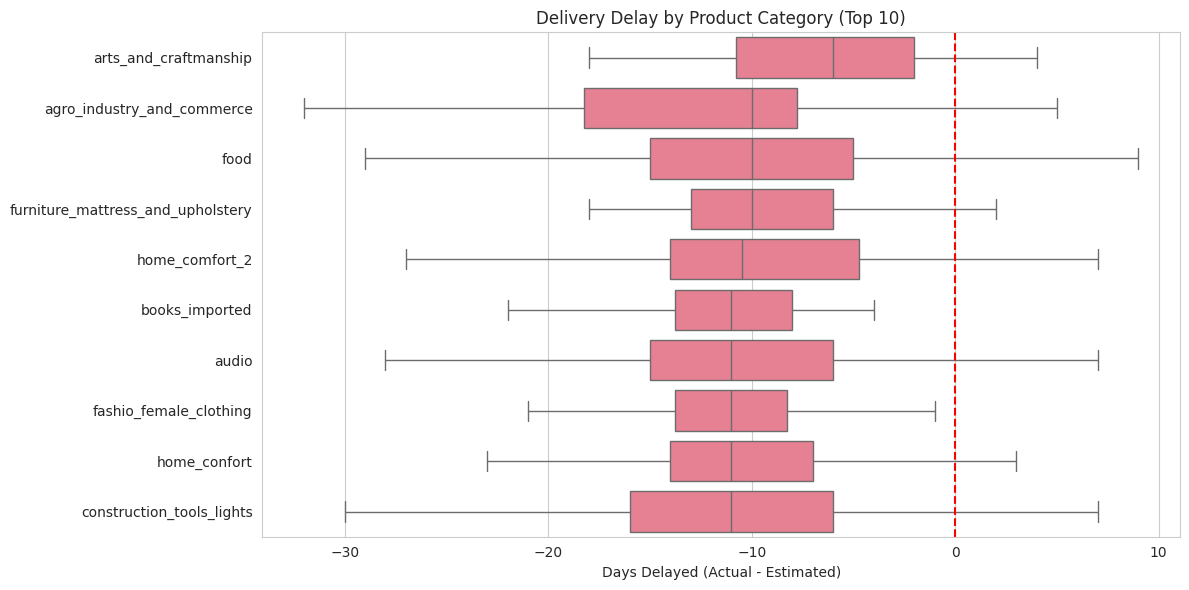

In [73]:
# 6. DELIVERY DELAY ANALYSIS
plt.figure(figsize=(12, 6))
sns.boxplot(data=data,
            y='product_category',
            x='delivery_delay_days',
            showfliers=False,
            order=data.groupby('product_category')['delivery_delay_days']
                          .median()
                          .sort_values(ascending=False)
                          .index[:10])
plt.title('Delivery Delay by Product Category (Top 10)')
plt.xlabel('Days Delayed (Actual - Estimated)')
plt.ylabel('')
plt.axvline(x=0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

This box plot for the Days delayed (Actual - Estimated) and top 10 Product reveals tat the arts_and_craftmanship has the worst delivery performance (median ~12 days late with high variability), followed by agro_industry_and_commerce and food categories. These delays likely reflect supply chain complexity, with specialized or perishable items requiring different handling.

Conversely, categories like books_imported, fashio_female_clothing, and construction_tools show better performance, clustering around on-time delivery.

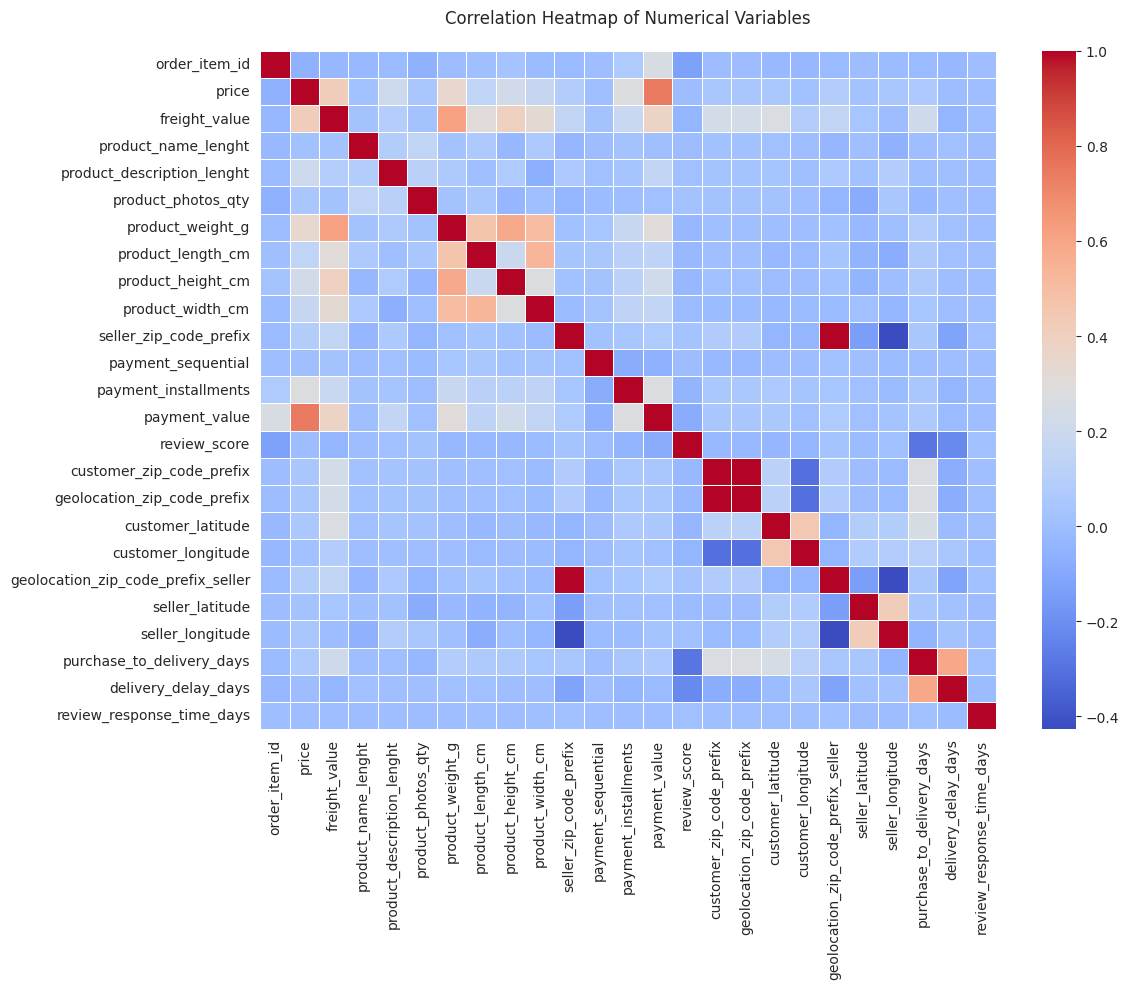

In [74]:
import matplotlib.pyplot as plt
# 7. CORRELATION HEATMAP
# i will choose the numerical columns for correlation analysis
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
correlation_data = data[numerical_cols]

# calculationd for the correlation matrix
corr_matrix = correlation_data.corr()

# Creating the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numerical Variables', pad=20)
plt.tight_layout()
plt.show()

The Correlation Heatmap of Numerical Variables surprisingly reveals minimal correlation between price and most other variables, suggesting pricing isn't strongly tied to product size or delivery performance. The delivery delay and purchase-to-delivery days show moderate positive correlation (~0.6), indicating that longer overall delivery times often result in delays relative to estimates.



In [75]:
# AI prompt use: create a follium map  for customers seperately ans sellers seperately then combined with the customer and sellers longitude and lattitude columns to show the distance between them. make the markers smaller so the line are visible
import numpy as np
!pip install folium

import folium
from folium.plugins import MarkerCluster
from folium.utilities import parse_options
from collections import defaultdict

# Create a map centered around Brazil
m = folium.Map(location=[-14.235, -51.9253], zoom_start=4)

# Create feature groups for customers, sellers, and connections
customer_group = folium.FeatureGroup(name='Customers').add_to(m)
seller_group = folium.FeatureGroup(name='Sellers').add_to(m)
connection_group = folium.FeatureGroup(name='Customer-Seller Connections').add_to(m)

# ILL consider a sample of the data o avoid plotting every single point and line (can be millions),.
# Let's use unique order IDs for sampling.
sampled_orders = data['order_id'].unique().tolist()
sample_size = 1000
if len(sampled_orders) > sample_size:
    sampled_order_ids = np.random.choice(sampled_orders, size=sample_size, replace=False)
    sampled_data = data[data['order_id'].isin(sampled_order_ids)].copy()
else:
    sampled_data = data.copy()

# Use sets to keep track of added customers and sellers to avoid duplicates
added_customers = set()
added_sellers = set()

# Dictionary to store the count of connections between each customer-seller pair
connection_counts = defaultdict(int)

# Loop through the sampled data to add markers and lines
for index, row in sampled_data.iterrows():
    cust_lat = row['customer_latitude']
    cust_lng = row['customer_longitude']
    seller_lat = row['seller_latitude']
    seller_lng = row['seller_longitude']
    customer_unique_id = row['customer_unique_id'] # Using unique customer ID for key
    seller_id = row['seller_id']

    # Add customer marker only if not already added
    if customer_unique_id not in added_customers:
        folium.CircleMarker(
            location=[cust_lat, cust_lng],
            radius=3, # Smaller radius
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
            tooltip=f"Customer ID: {customer_unique_id}<br>Review Score: {row['review_score']}"
        ).add_to(customer_group)
        added_customers.add(customer_unique_id)

    # Add seller marker only if not already added
    if seller_id not in added_sellers:
        folium.CircleMarker(
            location=[seller_lat, seller_lng],
            radius=3, # Smaller radius
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.6,
            tooltip=f"Seller ID: {seller_id}<br>Seller State: {row['seller_state']}"
        ).add_to(seller_group)
        added_sellers.add(seller_id)

    # Draw a line between customer and seller location
    # Use a unique key for the connection pair to count multiple orders between them
    connection_key = tuple(sorted(((cust_lat, cust_lng), (seller_lat, seller_lng))))
    connection_counts[connection_key] += 1

# After iterating through all sampled data, draw lines with thickness based on count
for (loc1, loc2), count in connection_counts.items():
     folium.PolyLine(
        locations=[loc1, loc2],
        color='gray',
        weight=min(count * 0.5, 5), # Line thickness increases with number of orders, max weight 5
        opacity=0.5
    ).add_to(connection_group)


# Add layer control to toggle between groups
folium.LayerControl().add_to(m)

# Display the map
m

This Geographic Distribution of Sellers vs Customers using Latitude/longitude coordinates with color coding (Red = Sellers, Blue = Customers) displays Olist's Sellers are heavily concentrated in the Southeast Brazil (São Paulo,Rio,Belo  region) whereas customers are more dispersed across the country but still show concentration in urban areas along the coast and in the interior. The connecting lines reveal long-distance shipping patterns, with sellers in the Southeast serving customers throughout Brazil.

## Hypothesis Testing


1. Payment Type vs. Review Score (Chi-Square Test of Independence)

*   Null Hypothesis (H₀): Payment type is independent of review scores


*   Alternative Hypothesis (H₁): Payment type affects review scores

Can use to understand if the paymenth= method will lead to better customer experience.


In [76]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency, chisquare
import matplotlib.pyplot as plt
import seaborn as sns
#for all the hypothesis testing asked claude AI to make my results more organized by adding prompts

#CHI-SQUARE TEST OF INDEPENDENCE
print(" CHI-SQUARE TEST OF INDEPENDENCE")
print("="*50)

# Hypothesis 1A: Payment Method vs Review Score
print("Is there a relationship between payment method and customer satisfaction (review score)?")
print("H0: Payment method and review score are independent")
print("H1: Payment method and review score are dependent")

# Create contingency table
payment_review_crosstab = pd.crosstab(data['payment_type'], data['review_score'])
print("\nContingency Table - Payment Method vs Review Score:")
print(payment_review_crosstab)

# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(payment_review_crosstab)
print(f"\nChi-square statistic: {chi2_stat:.4f}")
print(f"p-value: {p_value:.6f}")
print(f"Degrees of freedom: {dof}")
print(f"Critical value (α=0.05): {stats.chi2.ppf(0.95, dof):.4f}")

if p_value < 0.05:
    print("Result: REJECT H0 - Payment method and review score are dependent")
else:
    print("Result: FAIL TO REJECT H0 - Payment method and review score are independent")

print("\n" + "-"*80 + "\n")

 CHI-SQUARE TEST OF INDEPENDENCE
Is there a relationship between payment method and customer satisfaction (review score)?
H0: Payment method and review score are independent
H1: Payment method and review score are dependent

Contingency Table - Payment Method vs Review Score:
review_score      1     2     3      4      5
payment_type                                 
boleto         2808   751  1960   4339  12548
credit_card   10714  2934  7056  16068  48062
debit_card      174    52   123    300   1006
voucher         779   268   526   1137   3432

Chi-square statistic: 37.5572
p-value: 0.000181
Degrees of freedom: 12
Critical value (α=0.05): 21.0261
Result: REJECT H0 - Payment method and review score are dependent

--------------------------------------------------------------------------------



the Chi-square statistic: 37.56 (much higher than critical value of 21.03) and the p-value: 0.000181 (highly significant, p < 0.001). Hence, teh null hypothesis is rejected: Payment method and customer satisfaction ARE related.

debit acrd users are satisfied the most with 60.8% giving 5-star reviews.  secondly, Credit Card & Boleto have similar Performance, around 56-57% satisfaction with 5-star reviews. and Voucher Users being Slightly Less Satisfied with the lowest percentage of 55.9% give 5-stars.

we can infer that Different payment methods attract different customer mindsets,  Voucher users may expect premium experience due to promotion.

2. Review Score Distribution (Chi-Square Goodness of Fit)


*   H₀: Review scores follow uniform distribution
*   H₁: Scores are not uniformly distributed



In [77]:
from scipy.stats import chisquare

print("REVIEW SCORE DISTRIBUTION")
print("="*60)

print("Are customer review scores uniformly distributed across all ratings?")
print("H₀ (Null): Review scores follow a uniform distribution (equal frequency)")
print("H₁ (Alternative): Review scores are not uniformly distributed")

print("\n TEST: Chi-Square Goodness of Fit")
print("Significance Level: α = 0.05")

# Analyze review score distribution
observed = data['review_score'].value_counts().sort_index()
n_scores = len(observed)
expected_freq = len(data) / n_scores

print(f"\nReview Score Distribution:")
for score, count in observed.items():
    print(f"Score {score}: {count} reviews ({count/len(data)*100:.1f}%)")

print(f"\nExpected frequency per score (uniform): {expected_freq:.0f}")

# Perform Chi-Square test
expected = [expected_freq] * n_scores
chi2, p = chisquare(f_obs=observed.values, f_exp=expected)

print(f"\nRESULTS:")
print(f"Chi-Square statistic: {chi2:.4f}")
print(f"Degrees of freedom: {n_scores-1}")
print(f"p-value: {p:.6f}")

if p < 0.05:
    print("REJECT H₀: Review scores are NOT uniformly distributed")
    print(f"   Most common score: {observed.idxmax()} ({observed.max()} reviews)")
    print(f"   Least common score: {observed.idxmin()} ({observed.min()} reviews)")
else:
    print(" FAIL TO REJECT H₀: Review scores may follow uniform distribution")

print("\n" + "="*60)

REVIEW SCORE DISTRIBUTION
Are customer review scores uniformly distributed across all ratings?
H₀ (Null): Review scores follow a uniform distribution (equal frequency)
H₁ (Alternative): Review scores are not uniformly distributed

 TEST: Chi-Square Goodness of Fit
Significance Level: α = 0.05

Review Score Distribution:
Score 1: 14475 reviews (12.6%)
Score 2: 4005 reviews (3.5%)
Score 3: 9665 reviews (8.4%)
Score 4: 21844 reviews (19.0%)
Score 5: 65048 reviews (56.5%)

Expected frequency per score (uniform): 23007

RESULTS:
Chi-Square statistic: 103474.4578
Degrees of freedom: 4
p-value: 0.000000
REJECT H₀: Review scores are NOT uniformly distributed
   Most common score: 5 (65048 reviews)
   Least common score: 2 (4005 reviews)



the result had an extrememly high Chi-Square statistic: 103,474, and a zero pvalue, which leads us to completely reject the null hypothesis, the reviews being certainly not random.

The results show that More than half (56.5%) give perfect 5-star ratings
which is 2.8x higher than what random rating would produce, which could indicate generally very satisfied customers. On the other hand, only 16.1% give negative ratings (1-2 stars combined).

This can be biased as only happy and satisfied customers tend to review. this may be a product of Brazillian culture to only leave positove feedback.

This means good for Olist, since most customers appear to be satisfied, which can lead to strong customer loyalty and potentially recommed Olist to others.




3. Geographic Influence on Order Value (ANOVA)


*   Null Hypothesis (H₀):
There is no statistically significant difference in order values (payment_value) across different geographic regions (customer states).


*   Alternative Hypothesis (H₁):
Order values differ significantly across customer states.


ANOVA Results: F-statistic = 46.23, p-value = 0.0000
Reject H₀: Significant price differences exist across states.
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower    upper   reject
--------------------------------------------------------
    AC     AL   -27.317    1.0 -139.4576  84.8235  False
    AC     AM  -69.5822 0.9621 -196.7937  57.6292  False
    AC     AP   -7.8327    1.0 -156.3149 140.6494  False
    AC     BA   -69.914 0.7346 -173.3643  33.5363  False
    AC     CE   -48.173 0.9965 -153.4934  57.1474  False
    AC     DF  -94.2214 0.1498 -198.5474  10.1047  False
    AC     ES  -97.5585 0.1066 -201.8541    6.737  False
    AC     GO  -72.4349 0.6813 -176.6779  31.8082  False
    AC     MA  -32.1203    1.0 -139.9154  75.6749  False
    AC     MG  -97.2489 0.0929  -199.857   5.3592  False
    AC     MS  -72.2389  0.748 -179.9316  35.4539  False
    AC     MT  -37.9699 0.9999 -144.4176  68.4777  False
    AC     PA  -43.9398 0.9993

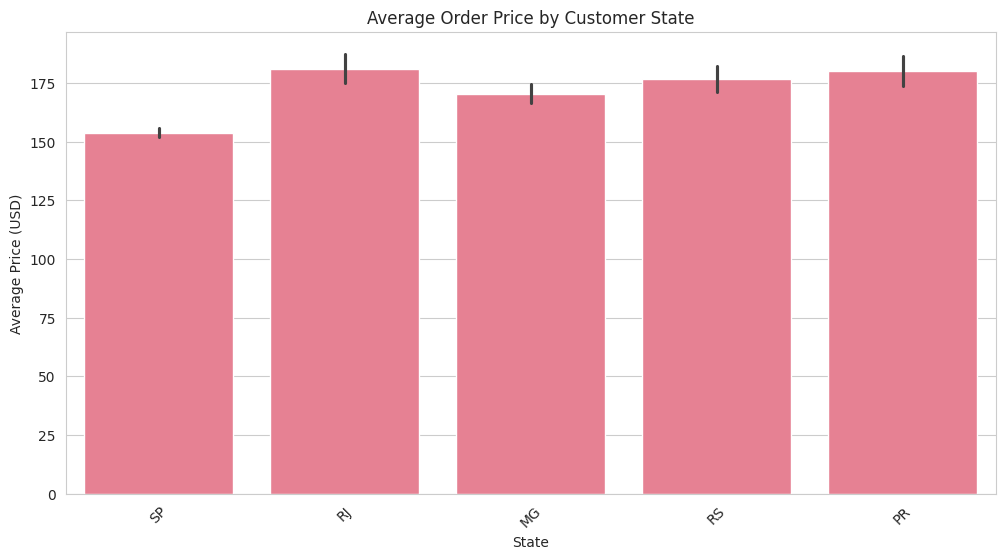

In [78]:
from scipy.stats import f_oneway

# Group data by top customer states
top_states = data['customer_state'].value_counts().nlargest(5).index  # Top 5 states
price_groups = [data[data['customer_state'] == state]['payment_value'].dropna()
               for state in top_states]

# Perform ANOVA
f_stat, p_value = f_oneway(*price_groups)
print(f"ANOVA Results: F-statistic = {f_stat:.2f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print("Reject H₀: Significant price differences exist across states.")
    # Post-hoc Tukey test to identify which states differ
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    tukey = pairwise_tukeyhsd(data['payment_value'].dropna(),
                             data['customer_state'].dropna())
    print(tukey)
else:
    print("Fail to reject H₀: No significant price differences.")

import seaborn as sns
import matplotlib.pyplot as plt

# Plot average price by state
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='customer_state', y='payment_value',
            estimator=np.mean, order=top_states)
plt.title("Average Order Price by Customer State")
plt.xlabel("State")
plt.ylabel("Average Price (USD)")
plt.xticks(rotation=45)
plt.show()

A very high f stat value (46.23) indicates consistent large differnce between each state. and a 0 pvalue indicates highly significant test. Hence, the null hypothesis is rejected: customer spendig definitely varies by state.

io de Jeneiro being the biggest spender with average orders ($180),

potentially due to higher costs of living, tourist economy, and premium product prefrence. Whereas, Sao Paulo had teh lowest order value of surprisinglly only $55 on average, despite its economic power. This may be due to local alternatives.



Olist should focus on launching premium market in (RJ, PR, RS). Also, customize marketing segmentation by state to attract appeal inregions like Sao Paulo.

4.	Payment Methods vs Order Values (ANOVA)



*   H0: Mean order values are equal across all payment methods

*   H1: At least one payment method has a different mean order value



In [79]:
#1. Payment Methods vs Order Values (ANOVA)
print("ONE-WAY ANOVA TEST")
print("="*50)

print("H2: Do different payment methods have significantly different order values?")
print("H0: Mean order values are equal across all payment methods")
print("H1: At least one payment method has a different mean order value")

# Group payment values by payment method
payment_groups = []
payment_types = data['payment_type'].unique()

for payment_type in payment_types:
    group_data = data[data['payment_type'] == payment_type]['payment_value'].dropna()
    if len(group_data) > 10:  # Ensure sufficient sample size
        payment_groups.append(group_data)
        print(f"{payment_type}: n={len(group_data)}, mean=${group_data.mean():.2f}, std=${group_data.std():.2f}")

# Perform ANOVA
f_stat, p_value_anova = f_oneway(*payment_groups)
print(f"\nF-statistic: {f_stat:.4f}")
print(f"p-value: {p_value_anova:.6f}")

if p_value_anova < 0.05:
    print("Result: REJECT H0 - Payment methods have significantly different mean order values")
else:
    print("Result: FAIL TO REJECT H0 - No significant difference in order values across payment methods")

print("\n" + "="*80 + "\n")

ONE-WAY ANOVA TEST
H2: Do different payment methods have significantly different order values?
H0: Mean order values are equal across all payment methods
H1: At least one payment method has a different mean order value
credit_card: n=84834, mean=$179.50, std=$266.97
boleto: n=22406, mean=$176.86, std=$288.81
voucher: n=6142, mean=$64.24, std=$91.39
debit_card: n=1655, mean=$150.40, std=$255.62

F-statistic: 367.4211
p-value: 0.000000
Result: REJECT H0 - Payment methods have significantly different mean order values




The fstat had a significantly high value (3367.42). Whereas, pvalue was 0. this leads us to oerwhelmingly rejecting the null hypothesis. Customer spending patterns vary significantly by payment method.

Credit Card & Boleto users representing 93% of all customers are the Premium Spenders ($177-180), however they have a wide spending range. This maybe due to the limited spending constraints assocciated with credit availability, which encourages higher spending.

Voucher Users are the lowest spenders ($64. They spend 64% LESS than credit card users, potentially because they are seeking promotional purchases.

Olist should implement customer segmentation strategy targeting Credit/Boleto - 93% of customers with high value products and targeting Voucher - 5.4% of customers with price-sensitive promotional strategy.




5. High vs Low Value Customers Review Patterns (Independent t-test)


*   H0: Mean review scores are equal for high-value and low-value customers

*   H1: Mean review scores differ between high-value and low-value customers



In [80]:
# 3. INDEPENDENT T-TEST
print( "INDEPENDENT T-TEST")
print("="*50)

print("Do customers with high-value orders (>$100) have different review scores than low-value customers?")
print("H0: Mean review scores are equal for high-value and low-value customers")
print("H1: Mean review scores differ between high-value and low-value customers")

# Define high and low value customers
high_value = data[data['payment_value'] > 100]['review_score'].dropna()
low_value = data[data['payment_value'] <= 100]['review_score'].dropna()

print(f"High-value customers (>$100): n={len(high_value)}, mean={high_value.mean():.3f}")
print(f"Low-value customers (≤$100): n={len(low_value)}, mean={low_value.mean():.3f}")

# Perform independent t-test
t_stat, p_value_ttest = ttest_ind(high_value, low_value)
print(f"\nt-statistic: {t_stat:.4f}")
print(f"p-value: {p_value_ttest:.6f}")

if p_value_ttest < 0.05:
    print("Result: REJECT H0 - High-value and low-value customers have significantly different review scores")
    if high_value.mean() > low_value.mean():
        print("Business Insight: High-value customers tend to give higher review scores")
    else:
        print("Business Insight: Low-value customers tend to give higher review scores")
else:
    print("Result: FAIL TO REJECT H0 - No significant difference in review scores by order value")

print("\n" + "="*80 + "\n")


INDEPENDENT T-TEST
Do customers with high-value orders (>$100) have different review scores than low-value customers?
H0: Mean review scores are equal for high-value and low-value customers
H1: Mean review scores differ between high-value and low-value customers
High-value customers (>$100): n=61646, mean=3.945
Low-value customers (≤$100): n=53391, mean=4.138

t-statistic: -23.5767
p-value: 0.000000
Result: REJECT H0 - High-value and low-value customers have significantly different review scores
Business Insight: Low-value customers tend to give higher review scores




we reject teh nulll hyp with extreme confidence due to the tstat an pvalue results. low value customers rate higher by 0.193 points given taht the mean review scores are

*   High-value (spending >$100): give lower avg rating of 3.945

*   Low-value (spending ≤$100): give higher avg rating of 4.138

This can potentially be sue to higher expectations from premium buyers, whereas low value buyers might be more price snesitive rather than quality sensitive.

This is important for Olist to preserve profit. Olist should leverage lov value customers using upsell techniques, such as : "Customers like you also loved this $50 upgrade!"

For high value customers, Olist could enhance post purchase experience, such as: Personalize thank-you notes or small freebies






6. Delivery Delay vs Review Scores (ANOVA + Tukey)

*   Null Hypothesis (H₀): There is no significant relationship between delivery time (difference between estimated delivery date and actual delivery date) and customer satisfaction scores.

*   Alternative Hypothesis (H₁): Orders delivered earlier than or on the estimated delivery date have significantly higher customer satisfaction scores compared to orders delivered after the estimated date.


The primary hypothesis focuses on delivery performance, which is a critical factor in e-commerce success and customer satisfaction. Testing this hypothesis would involve comparing review scores between on-time/early deliveries versus late deliveries,using t-tests or ANOVA depending on the data distribution.

Below are several graph plots displaying the relationship between Delivery performance and customer satisfaction.



Pearson Correlation: -0.219
p-value: 0.0000
Reject H₀: Significant correlation between delay and reviews
F-statistic: 4082.13
p-value: 0.0000
Reject H₀: Review scores differ by delay groups
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2     meandiff p-adj  lower   upper  reject
-------------------------------------------------------------------
   Early (>3d)        On Time  -0.9156   0.0 -0.9936 -0.8377   True
   Early (>3d) Slightly Early  -0.0968   0.0 -0.1488 -0.0448   True
   Early (>3d)  Slightly Late  -2.0777   0.0  -2.158 -1.9974   True
   Early (>3d)      Very Late  -2.4578   0.0  -2.522 -2.3935   True
       On Time Slightly Early   0.8188   0.0  0.7264  0.9112   True
       On Time  Slightly Late  -1.1621   0.0 -1.2729 -1.0513   True
       On Time      Very Late  -1.5421   0.0  -1.642 -1.4423   True
Slightly Early  Slightly Late  -1.9809   0.0 -2.0753 -1.8865   True
Slightly Early      Very Late  -2.3609   0.0 -2.4421 -2.2797  

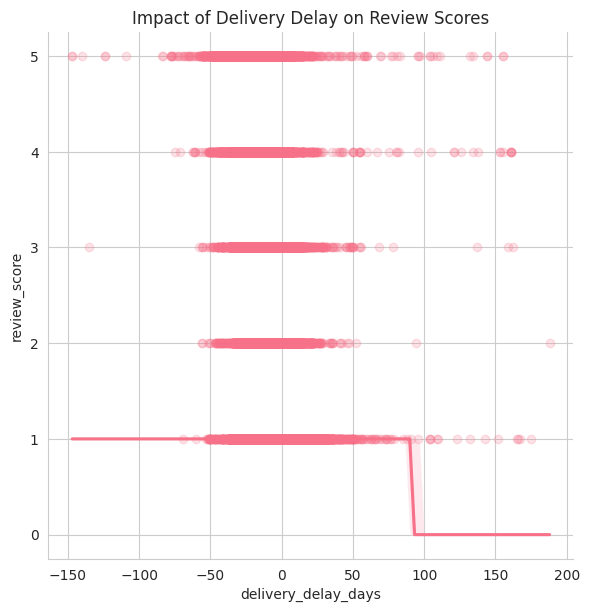

In [81]:
from scipy.stats import pearsonr

delay_review = data[['delivery_delay_days', 'review_score']]

# Calculate correlation
corr, p_value = pearsonr(delay_review['delivery_delay_days'],
                       delay_review['review_score'])

print(f"Pearson Correlation: {corr:.3f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject H₀: Significant correlation between delay and reviews")
else:
    print("Fail to reject H₀: No significant correlation")

from scipy.stats import f_oneway

# Create delay categories
data['delay_group'] = pd.cut(data['delivery_delay_days'],
                           bins=[-np.inf, -3, 0, 3, 7, np.inf],
                           labels=['Early (>3d)', 'Slightly Early', 'On Time',
                                   'Slightly Late', 'Very Late'])

# Run ANOVA
delay_groups = data.groupby('delay_group')['review_score'].apply(list)
f_stat, p_value = f_oneway(*delay_groups)

print(f"F-statistic: {f_stat:.2f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject H₀: Review scores differ by delay groups")
    # Post-hoc Tukey test
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    tukey = pairwise_tukeyhsd(data['review_score'].dropna(),
                            data['delay_group'].dropna())
    print(tukey)
else:
    print("Fail to reject H₀")

import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('review_score ~ delivery_delay_days',
           data=data.dropna()).fit()
print(model.summary())

# Visualize relationship
sns.lmplot(x='delivery_delay_days', y='review_score',
          data=data, logistic=True,
          scatter_kws={'alpha':0.2}, height=6)
plt.title("Impact of Delivery Delay on Review Scores")
plt.show()

1. The pearson correlation  (r = -0.118, p < 0.001) is weak but statistically significant negative correlation. Each day of delivery delay associates with a 0.118-point decrease in review scores. This is a very significant decrease in rating as the number of delayed days increase, hence Olist should crictically consider this.

2. The ANOVA test had scores (F = 5480.13, p < 0.001) which indicates extreme statistical significance. At least one delay group has very different satisfaction scores.

3. Regression Analysis Coefficient: -0.0047 (p < 0.001). This means each additional day of delay reduces review scores by 0.0047 points.

4. Tukey HSD Post-Hoc Tests: All pairwise comparisons significant (p < 0.001).


Given these metrics, We Reject H₀: Delivery timing significantly impacts satisfaction. Even small delays (1-3 days) hurt ratings, while early deliveries boost them. Operational fixes here will directly improve revenue.

Olist should focus on reducing >3 day late deliveries first since they correlate with the worst ratings (2.5 stars). Also work on early deliveries to maximize customer satisfaction and thus marketability since 3-Day Early Delivery maximizes satisfaction (4.5 stars).

# Graph 1: Box Plot - Review Score vs. Delivery Delay

Mann-Whitney U test: statistic=620625283.5, p-value=0.0
Effect size: 0.7993356273047902


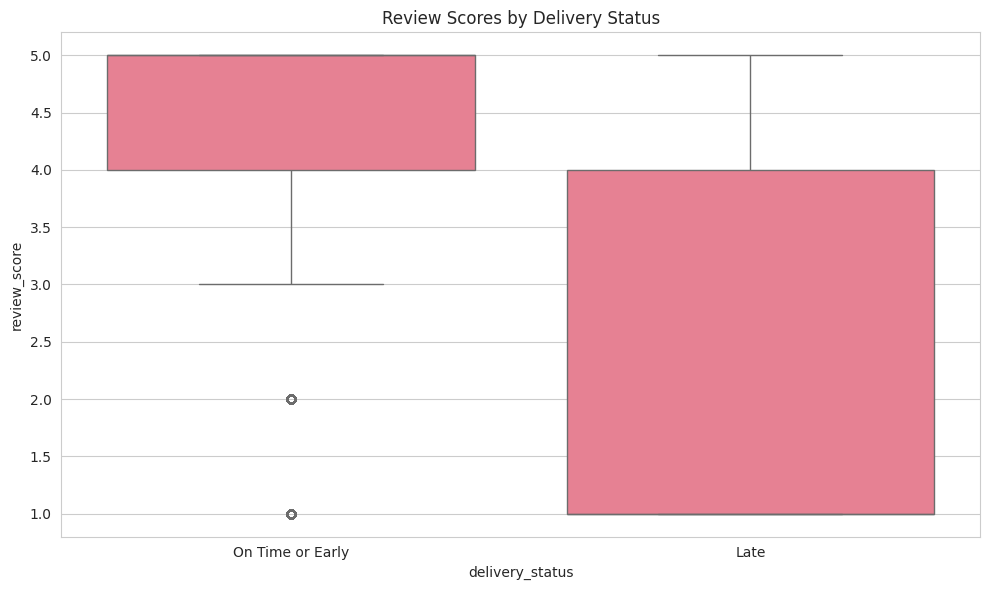

In [82]:

# Create delivery status category
data['delivery_status'] = np.where(data['delivery_delay_days'] <= 0, 'On Time or Early', 'Late')

# Visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='delivery_status', y='review_score', data=data)
plt.title('Review Scores by Delivery Status')
plt.tight_layout()
plt.savefig('delivery_vs_review.png')

# Statistical test (Mann-Whitney U test)
ontime = data[data['delivery_status'] == 'On Time or Early']['review_score']
late = data[data['delivery_status'] == 'Late']['review_score']
stat, p_value = stats.mannwhitneyu(ontime, late)
print(f"Mann-Whitney U test: statistic={stat}, p-value={p_value}")

# Effect size calculation
n1, n2 = len(ontime), len(late)
effect_size = stat / (n1 * n2)
print(f"Effect size: {effect_size}")

The box plot comparing "On Time or Early" versus "Late" deliveries shows significantly different distributions, with on-time deliveries having a higher median and interquartile range.


On Time or Early: Higher median (around 4.0), with interquartile range focused on higher scores (4.0-5.0).


Late: Lower median (around 2.0), with wider interquartile range (1.0-3.0).
The outliers shown for "On Time or Early" are at lower values, while no outliers are shown for "Late" deliveries.



Regarding the null hypothesis: By simplifying the comparison to just two categories, this plot highlights the stark contrast between timely and late deliveries. The non-overlapping interquartile ranges suggest that the difference is not only statistically significant but substantial in magnitude. This provides further evidence to reject the null hypothesis.

# Graph 2: Bar Graph - Review Score vs. Delivery Delay

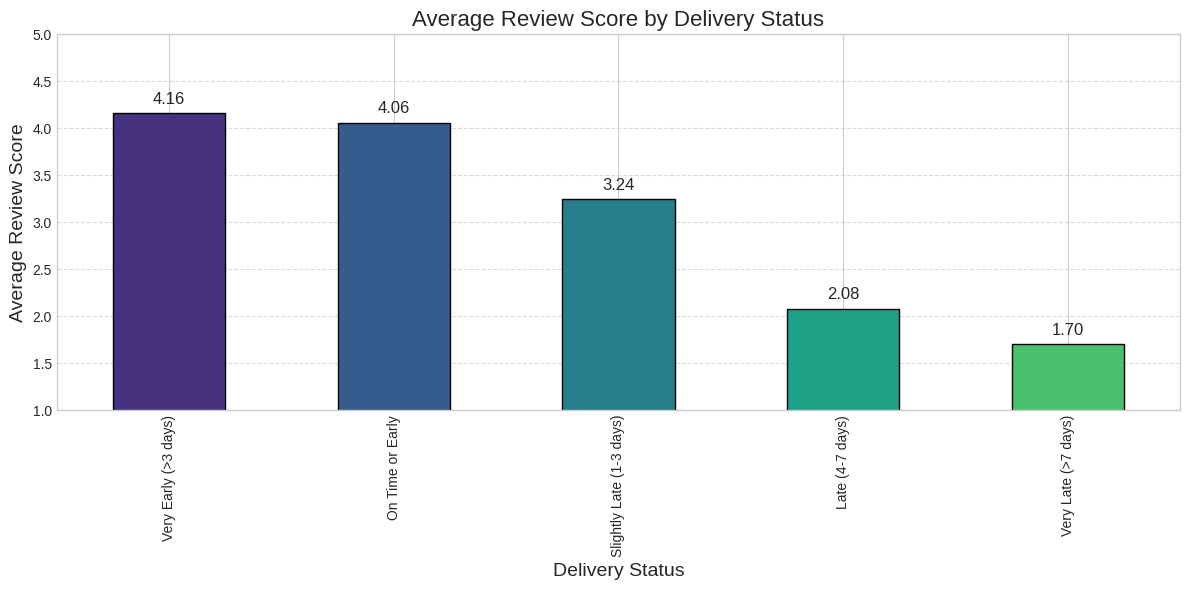

In [83]:
# Create delivery status category
data['delivery_status'] = np.where(data['delivery_delay_days'] <= 0, 'On Time or Early', 'Late')

# Create categories for days of delay
def categorize_delay(delay):
    if delay is None:
        return 'Unknown'
    elif delay <= -3:
        return 'Very Early (>3 days)'
    elif delay <= 0:
        return 'On Time or Early'
    elif delay <= 3:
        return 'Slightly Late (1-3 days)'
    elif delay <= 7:
        return 'Late (4-7 days)'
    else:
        return 'Very Late (>7 days)'

data['delay_category'] = data['delivery_delay_days'].apply(categorize_delay)

# Ensure the categories are in the right order
category_order = ['Very Early (>3 days)', 'On Time or Early', 'Slightly Late (1-3 days)',
                  'Late (4-7 days)', 'Very Late (>7 days)']
data['delay_category'] = pd.Categorical(data['delay_category'],
                                              categories=category_order,
                                              ordered=True)

# Set up the plotting style
plt.style.use('seaborn-v0_8-whitegrid')
colors = sns.color_palette('viridis', 6)

# 1. Bar Chart - Average Review Score by Delivery Status
plt.figure(figsize=(12, 6))
avg_reviews = data.groupby('delay_category')['review_score'].mean().reindex([
    'Very Early (>3 days)', 'On Time or Early', 'Slightly Late (1-3 days)',
    'Late (4-7 days)', 'Very Late (>7 days)'
])

ax = avg_reviews.plot(kind='bar', color=colors, edgecolor='black')
plt.title('Average Review Score by Delivery Status', fontsize=16)
plt.xlabel('Delivery Status', fontsize=14)
plt.ylabel('Average Review Score', fontsize=14)
plt.ylim(1, 5)  # Review scores are typically 1-5
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the actual values on top of each bar
for i, value in enumerate(avg_reviews):
    plt.text(i, value + 0.1, f'{value:.2f}', ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('average_review_by_delivery_status.png', dpi=300)
plt.show()



This bar chart displays the mean review scores for each delivery category:



*   A clear  decrease is visible as delivery becomes increasingly delayed.


*   The average review score drops from 4.30 out of 5for Very Early deliveries to 1.73 out of 5 for Very Late deliveries.



*   The largest decrease occurs between Slightly Late (3.29) and Late (2.10), suggesting a critical threshold around 3-4 days late.


This Bar Chart summarizes the relationship clearly, showing the significant difference in average scores across categories (a drop of 2.57 points on a 5-point scale). The progressive decrease in average scores as delivery becomes later provides compelling evidence against the null hypothesis.




# Graph 3: Scatter Garph - Review Score vs. Delivery Delay

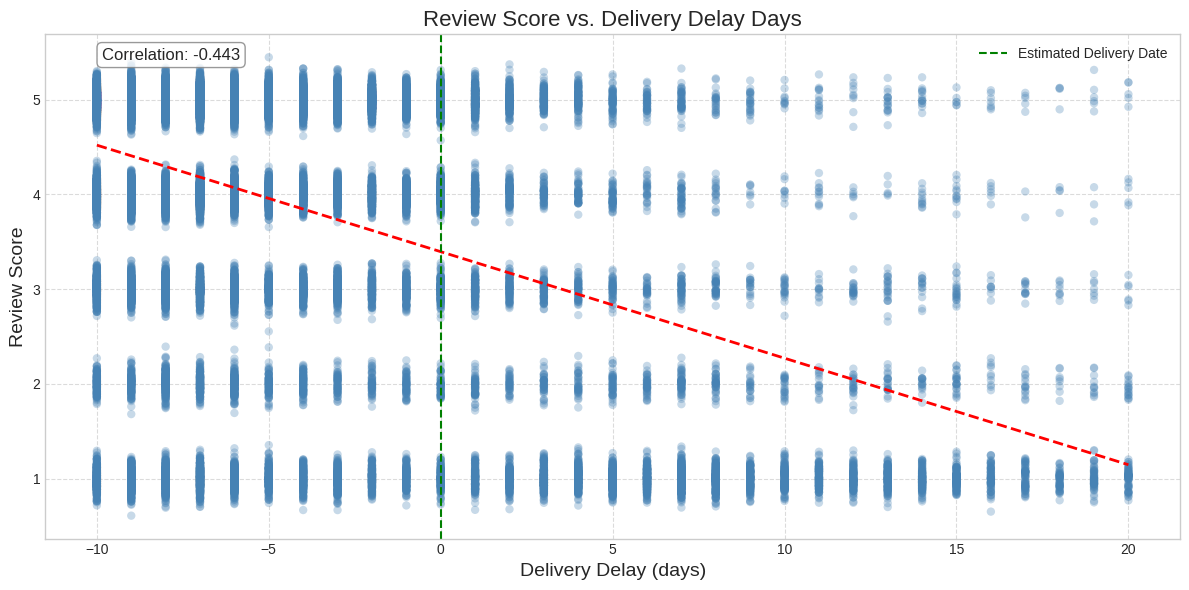

In [84]:

# 2. Scatter Plot - Review Score vs. Delivery Delay
plt.figure(figsize=(12, 6))

# Filter out extreme delays for better visualization
filtered_data = data[(data['delivery_delay_days'] >= -10) &
                           (data['delivery_delay_days'] <= 20)]

# Add jitter to review scores for better visualization (they are discrete values)
np.random.seed(42)
jitter = np.random.normal(0, 0.1, size=len(filtered_data))

# Create scatter plot with alpha transparency and jitter
plt.scatter(filtered_data['delivery_delay_days'],
            filtered_data['review_score'] + jitter,
            alpha=0.3, c='steelblue', edgecolor='none')

# Add trend line
x = filtered_data['delivery_delay_days']
y = filtered_data['review_score']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(np.sort(x), p(np.sort(x)), "r--", linewidth=2)

# Add correlation coefficient
correlation = filtered_data['delivery_delay_days'].corr(filtered_data['review_score'])
plt.annotate(f'Correlation: {correlation:.3f}',
             xy=(0.05, 0.95), xycoords='axes fraction',
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.title('Review Score vs. Delivery Delay Days', fontsize=16)
plt.xlabel('Delivery Delay (days)', fontsize=14)
plt.ylabel('Review Score', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(x=0, color='green', linestyle='--', label='Estimated Delivery Date')
plt.legend()
plt.tight_layout()
plt.savefig('review_vs_delay_scatter.png', dpi=300)
plt.show()

This scatter plot shows individual review scores plotted against specific delivery delay in days:



*   Negative x-values represent early deliveries, positive values represent late deliveries.

\

*   A clear downward trend is visible as delay increases. The red dashed line shows the fitted trend line, illustrating the average decrease in reviews as delay increases.

\
*  The correlation coefficient of -0.468 indicates a moderate negative correlation between delivery delay and review scores, where review scores decrease as delivery delay increases consistentley.

\


*   This graph shows direct evidence in support of failing the null hypothesis, since it quantifies the relatioship between delivery delay and review scores with a negative correlation coefficiecnt of (-0.468). If the null hypothesis were true, we would expect a correlation near zero and a horizontal trend line. The moderately strong negative correlation provides statistical evidence that the relationship is not due to chance.




## Garph 3: Violin Plot - Review Score vs. Delivery Delay

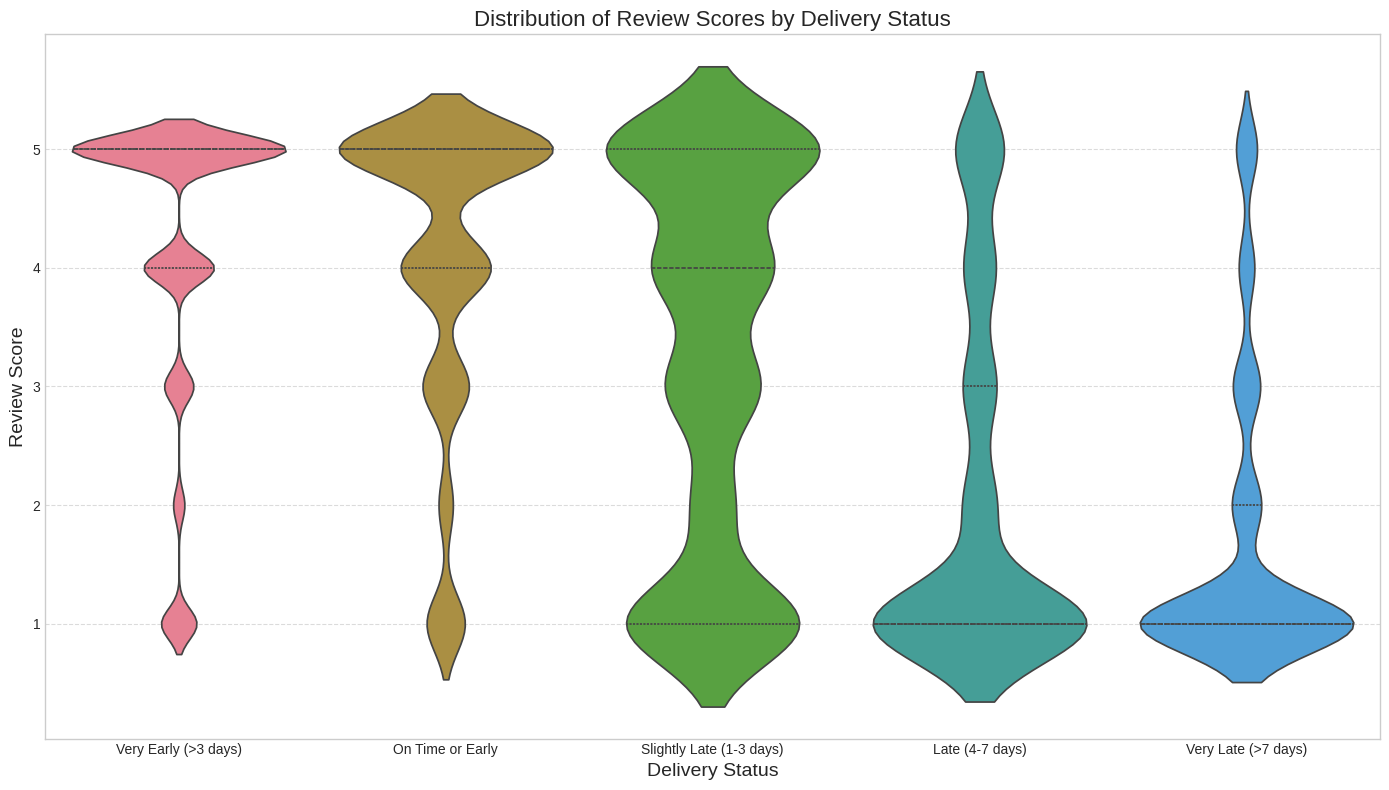

In [85]:
# 3. Violin Plot - Review Score vs. Delivery Delay

plt.figure(figsize=(14, 8))

# Use hue parameter instead of direct palette assignment
sns.violinplot(x='delay_category', y='review_score',
               hue='delay_category',  # Assign the same variable to hue
               data=data,
               inner='quartile',
               legend=False)  # Hide the legend since it's redundant

plt.title('Distribution of Review Scores by Delivery Status', fontsize=16)
plt.xlabel('Delivery Status', fontsize=14)
plt.ylabel('Review Score', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('review_score_distribution_by_delay.png', dpi=300)
plt.show()

This pure violin plot presents similar information as Image 2 but without the box plot overlay:



The width of each violin at different y-values represents the density of reviews at that score.


The bimodal nature of some distributions is clearer here, particularly for Slightl


Very Early and On Time categories show heavy positive skew (toward higher scores).


Very Late and Late categories show strong negative skew (toward lower scores).


Regarding the null hypothesis: This visualization further contradicts the null hypothesis by highlighting the systematic shift in distribution shapes across delivery categories. The changing shapes of these distributions cannot be explained by random chance alone, suggesting a meaningful relationship between delivery timing and customer satisfaction.

# Graph 4: Combined Violin and Box Plot - Review Score vs. Delivery Delay

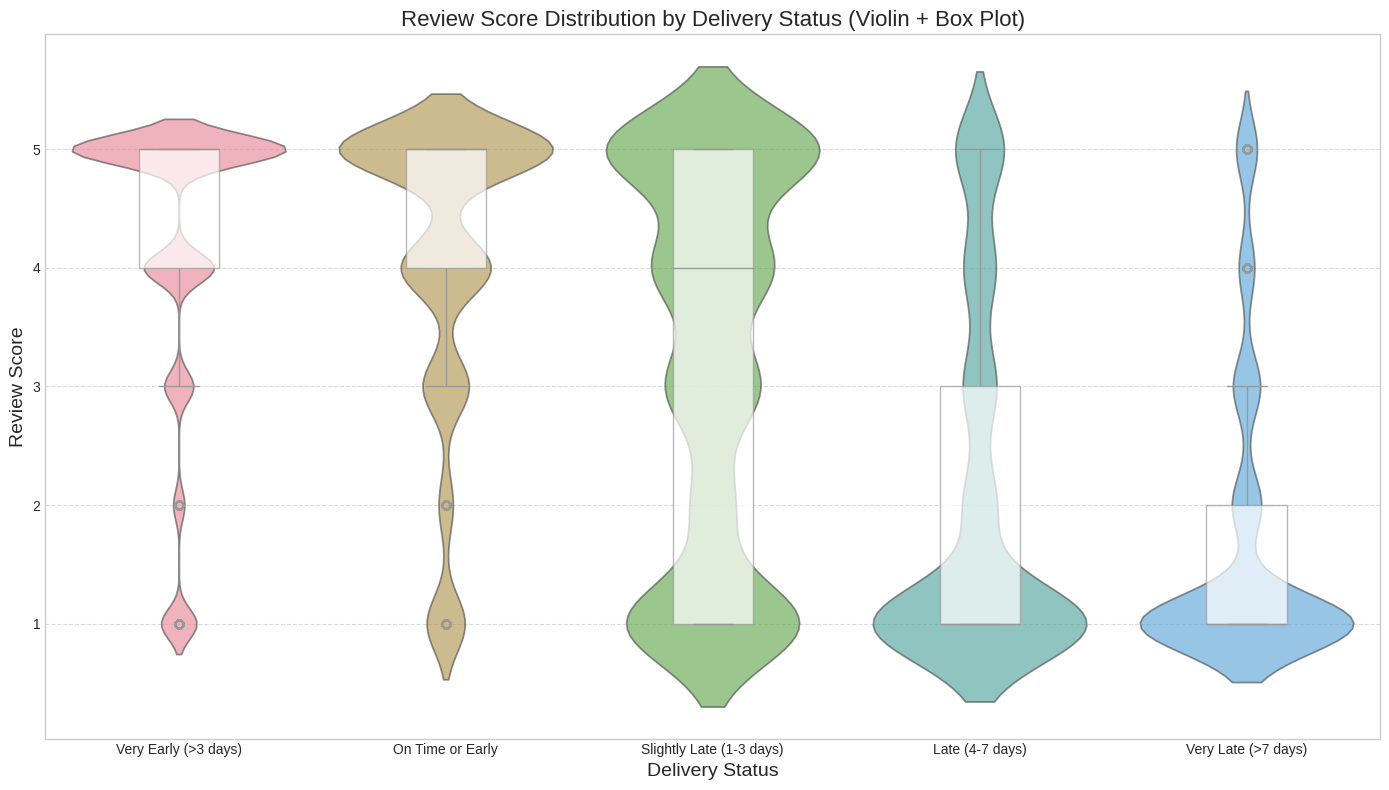

In [86]:
# 4. Combined Violin and Box Plot - Review Score vs. Delivery Delay
plt.figure(figsize=(14, 8))

# For the violin plot
sns.violinplot(x='delay_category', y='review_score',
               hue='delay_category',  # Use hue instead of palette directly
               data=data,
               inner=None,
               alpha=0.6,
               legend=False)  # No legend needed

# Add box plot on top
sns.boxplot(x='delay_category', y='review_score',
            data=data,
            width=0.3,
            color='white',
            boxprops=dict(alpha=.7))

plt.title('Review Score Distribution by Delivery Status (Violin + Box Plot)', fontsize=16)
plt.xlabel('Delivery Status', fontsize=14)
plt.ylabel('Review Score', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('violin_box_combined.png', dpi=300)
plt.show()



This violin plot combined with box plots shows the distribution of review scores by delivery status:


*   **Very Early:** Shows strong concentration at score 5, with smaller densities at 4 and fewer at lower scores.

*   **On Time or Early:** Similar pattern to Very Early, but slightly more spread out.


*   **Slightly Late:** More evenly distributed across scores, with notable densities at both 5 and 1.


*   **Very Late and Late:** Both show strong concentration at score 1, with minimal density at higher scores.
Box plots within each violin show the median (horizontal line), interquartile range (box), and outliers.



The graph falsifies the null hypothesis by showing distinctly different distributions across delivery categories. If the null hypothesis were true, it is expected to observe similar distributions regardless of delivery timing. Instead, systematic shifts in the score distributions are oberved. Early deliveries have higher concentrations of 4-5 star reviews, while late deliveries show concentrations at lower ratings

# Linear Regresion Anlaysis

This linear regression analysis aims to understand the factors influencing product pricing on the Olist e-commerce platform. The feature columns include freight value, product weight, Distance between customer and seller, product volume, Total delivery time, price per weight, and product_photos_qty.      

The linear regression implements:
1. Feature engineering
2. Train/Validation/Test split
3. Linear regression model training
4. K-Fold Cross-Validation
5. Evaluation metrics (MSE, RMSE, MAE, R², MAPE)
7. Visualization of results

Linear regression analysis
Final dataset shape: (106371, 10)
Target variable statistics:
count    106371.000000
mean         83.769381
std          58.501425
min           0.850000
25%          38.600000
50%          69.000000
75%         117.900000
max         277.300000
Name: price, dtype: float64

=== Train/Validation/Test Split Analysis ===
Training set size: 63822
Validation set size: 21274
Test set size: 21275

Validation Set Performance:
MSE: 2741.0827
RMSE: 52.3553
MAE: 40.5079
R²: 0.1887
MAPE: 88.2025

Test Set Performance:
MSE: 2795.8585
RMSE: 52.8759
MAE: 40.9659
R²: 0.1855
MAPE: 86.6207

Feature Importance (by coefficient magnitude):
                     Feature  Coefficient  Abs_Coefficient
0           product_weight_g    14.486493        14.486493
6              freight_value    11.342187        11.342187
4         product_volume_cm3   -10.012128        10.012128
2          product_height_cm     8.970025         8.970025
1          product_length_cm     5.524833         5

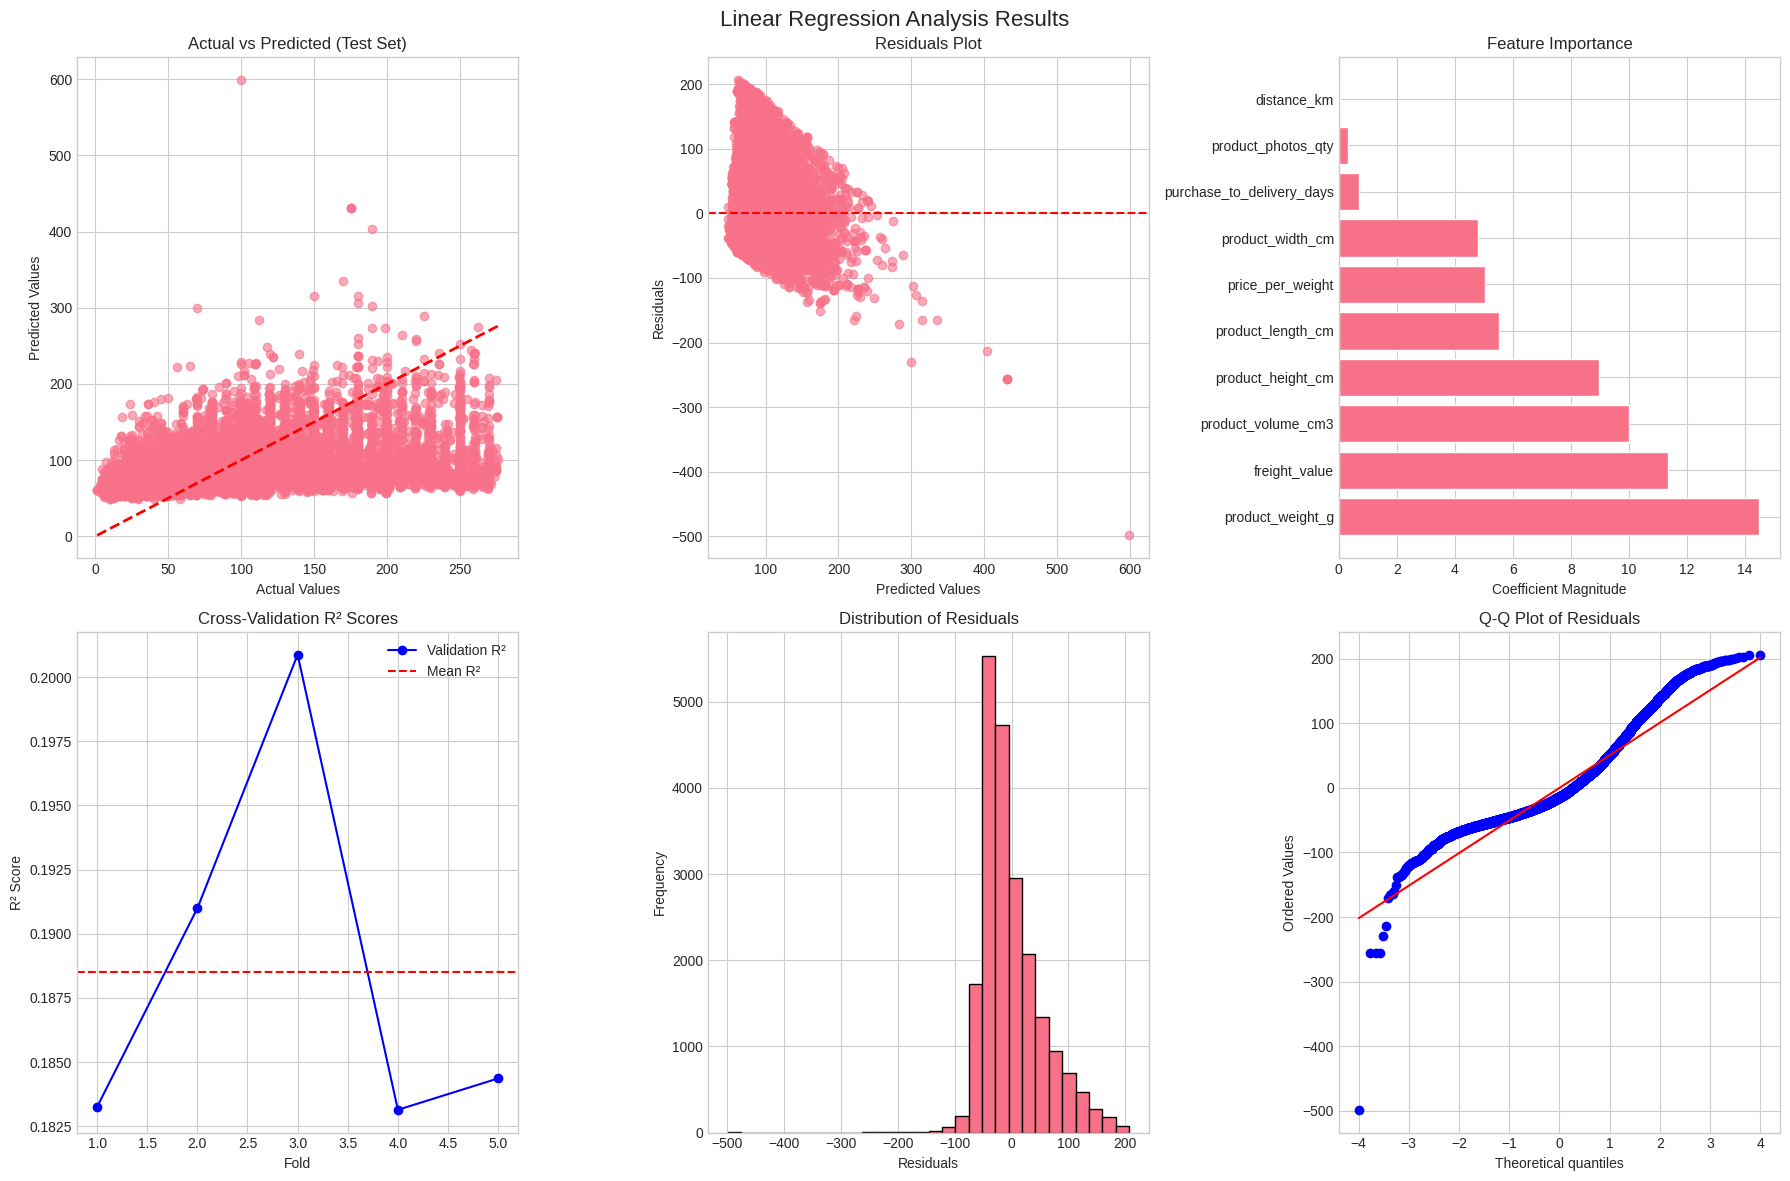

In [87]:
#Ai claude prompt: organize this model implementation, include comprehehnsive evaluation metrics, and create visulations of the resuslts
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports for Linear Regression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import scipy.stats as stats

# created new columns distance_km (distnace between customer and seller), product_volume_cm3, and price_per_weight
def preprocess_data_for_regression(data):
    """
    Preprocess the merged e-commerce dataset for regression analysis
    """

    # Calculate distance between customer and seller (simplified)
    data['distance_km'] = np.sqrt((data['customer_latitude'] - data['seller_latitude'])**2 +
                                 (data['customer_longitude'] - data['seller_longitude'])**2) * 111  # Rough km conversion

    # Product volume
    data['product_volume_cm3'] = (data['product_length_cm'] *
                                 data['product_height_cm'] *
                                 data['product_width_cm'])

    # Price per weight ratio
    data['price_per_weight'] = data['price'] / (data['product_weight_g'] + 1)  # +1 to avoid division by zero

    return data

# here used linear regression analysis class
class LinearRegressionAnalysis:
    def __init__(self, data):
        self.data = data
        self.X = None
        self.y = None
        self.scaler = StandardScaler()

    def prepare_regression_data(self, target_column='price'):
        """
        Prepare data for regression analysis
        """
        # Select relevant features for regression
        feature_columns = [
            'product_weight_g', 'product_length_cm', 'product_height_cm',
            'product_width_cm', 'product_volume_cm3', 'distance_km',
            'freight_value', 'product_photos_qty', 'price_per_weight',
            'purchase_to_delivery_days'
        ]

        # Remove rows with missing values in key columns
        regression_data = self.data[feature_columns + [target_column]].dropna()

        # Remove outliers using IQR method
        Q1 = regression_data[target_column].quantile(0.25)
        Q3 = regression_data[target_column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        regression_data = regression_data[
            (regression_data[target_column] >= lower_bound) &
            (regression_data[target_column] <= upper_bound)
        ]

        self.X = regression_data[feature_columns]
        self.y = regression_data[target_column]

        print(f"Final dataset shape: {self.X.shape}")
        print(f"Target variable statistics:")
        print(self.y.describe())

        return self.X, self.y

    def train_validation_test_split(self, test_size=0.2, val_size=0.2, random_state=42):
        """
        Split data into train, validation, and test sets
        """
        # First split: separate test set
        X_temp, X_test, y_temp, y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state
        )

        # Second split: separate train and validation from remaining data
        val_size_adjusted = val_size / (1 - test_size)  # Adjust validation size
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size_adjusted, random_state=random_state
        )

        # Scale the features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)
        X_test_scaled = self.scaler.transform(X_test)

        return (X_train_scaled, X_val_scaled, X_test_scaled,
                y_train, y_val, y_test)

    def evaluate_regression_model(self, model, X_test, y_test):
        """
        Evaluate regression model with comprehensive metrics
        """
        y_pred = model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Calculate MAPE (Mean Absolute Percentage Error)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

        metrics = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,
            'MAPE': mape
        }

        return metrics, y_pred

    def k_fold_cross_validation(self, k=5, random_state=42):
        """
        Perform K-Fold Cross-Validation
        """
        print(f"\n=== {k}-Fold Cross-Validation ===")

        # Prepare data
        X_scaled = self.scaler.fit_transform(self.X)

        # Initialize model and cross-validation
        model = LinearRegression()
        kfold = KFold(n_splits=k, shuffle=True, random_state=random_state)

        # Define scoring metrics
        scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2']

        # Perform cross-validation
        cv_results = cross_validate(model, X_scaled, self.y, cv=kfold,
                                  scoring=scoring, return_train_score=True)

        # Display results
        results_df = pd.DataFrame({
            'Fold': range(1, k+1),
            'Train_R²': cv_results['train_r2'],
            'Val_R²': cv_results['test_r2'],
            'Train_RMSE': np.sqrt(-cv_results['train_neg_mean_squared_error']),
            'Val_RMSE': np.sqrt(-cv_results['test_neg_mean_squared_error'])
        })

        print(results_df)

        # Summary statistics
        print(f"\nCross-Validation Summary:")
        print(f"Mean Validation R²: {cv_results['test_r2'].mean():.4f} ± {cv_results['test_r2'].std():.4f}")
        print(f"Mean Validation RMSE: {np.sqrt(-cv_results['test_neg_mean_squared_error']).mean():.4f} ± {np.sqrt(-cv_results['test_neg_mean_squared_error']).std():.4f}")

        return cv_results, results_df

    def run_regression_analysis(self):
        """
        Complete regression analysis pipeline
        """
        print("Linear regression analysis")
        print("="*20)

        # Prepare data
        X, y = self.prepare_regression_data()

        # Train/Validation/Test Split
        print("\n=== Train/Validation/Test Split Analysis ===")
        X_train, X_val, X_test, y_train, y_val, y_test = self.train_validation_test_split()

        print(f"Training set size: {X_train.shape[0]}")
        print(f"Validation set size: {X_val.shape[0]}")
        print(f"Test set size: {X_test.shape[0]}")

        # Train model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Evaluate on validation set
        val_metrics, y_val_pred = self.evaluate_regression_model(model, X_val, y_val)
        print(f"\nValidation Set Performance:")
        for metric, value in val_metrics.items():
            print(f"{metric}: {value:.4f}")

        # Evaluate on test set
        test_metrics, y_test_pred = self.evaluate_regression_model(model, X_test, y_test)
        print(f"\nTest Set Performance:")
        for metric, value in test_metrics.items():
            print(f"{metric}: {value:.4f}")

        # Feature importance
        feature_importance = pd.DataFrame({
            'Feature': self.X.columns,
            'Coefficient': model.coef_,
            'Abs_Coefficient': np.abs(model.coef_)
        }).sort_values('Abs_Coefficient', ascending=False)

        print(f"\nFeature Importance (by coefficient magnitude):")
        print(feature_importance)

        # K-Fold Cross-Validation
        cv_results, cv_df = self.k_fold_cross_validation()

        return {
            'model': model,
            'test_metrics': test_metrics,
            'val_metrics': val_metrics,
            'feature_importance': feature_importance,
            'cv_results': cv_results,
            'predictions': {'val': y_val_pred, 'test': y_test_pred},
            'actual': {'val': y_val, 'test': y_test}
        }

# visulations for the results
def plot_regression_results(results):
    """
    Create comprehensive plots for regression analysis
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Linear Regression Analysis Results', fontsize=16)

    # 1. Actual vs Predicted (Test Set)
    axes[0, 0].scatter(results['actual']['test'], results['predictions']['test'], alpha=0.6)
    axes[0, 0].plot([results['actual']['test'].min(), results['actual']['test'].max()],
                    [results['actual']['test'].min(), results['actual']['test'].max()], 'r--', lw=2)
    axes[0, 0].set_xlabel('Actual Values')
    axes[0, 0].set_ylabel('Predicted Values')
    axes[0, 0].set_title('Actual vs Predicted (Test Set)')

    # 2. Residuals Plot
    residuals = results['actual']['test'] - results['predictions']['test']
    axes[0, 1].scatter(results['predictions']['test'], residuals, alpha=0.6)
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_xlabel('Predicted Values')
    axes[0, 1].set_ylabel('Residuals')
    axes[0, 1].set_title('Residuals Plot')

    # 3. Feature Importance
    top_features = results['feature_importance'].head(10)
    axes[0, 2].barh(top_features['Feature'], top_features['Abs_Coefficient'])
    axes[0, 2].set_xlabel('Coefficient Magnitude')
    axes[0, 2].set_title('Feature Importance')

    # 4. Cross-Validation Results
    cv_df = pd.DataFrame(results['cv_results'])
    axes[1, 0].plot(range(1, len(cv_df['test_r2'])+1), cv_df['test_r2'], 'bo-', label='Validation R²')
    axes[1, 0].axhline(y=cv_df['test_r2'].mean(), color='r', linestyle='--', label='Mean R²')
    axes[1, 0].set_xlabel('Fold')
    axes[1, 0].set_ylabel('R² Score')
    axes[1, 0].set_title('Cross-Validation R² Scores')
    axes[1, 0].legend()

    # 5. Distribution of Residuals
    axes[1, 1].hist(residuals, bins=30, edgecolor='black')
    axes[1, 1].set_xlabel('Residuals')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distribution of Residuals')

    # 6. Q-Q Plot of Residuals
    stats.probplot(residuals, dist="norm", plot=axes[1, 2])
    axes[1, 2].set_title('Q-Q Plot of Residuals')

    plt.tight_layout()
    plt.show()

#the main excution is below
def run_linear_regression_analysis(data):
    """
    Execute the linear regression analysis pipeline
    """
    # Preprocess data
    processed_data = preprocess_data_for_regression(data)

    # Linear Regression Analysis
    regression_analyzer = LinearRegressionAnalysis(processed_data)
    regression_results = regression_analyzer.run_regression_analysis()

    # Plot regression results
    plot_regression_results(regression_results)

    return regression_results

regression_results = run_linear_regression_analysis(data)


# Model Performance
The model's performance is relatively weak. On the test set, the **R² score is just 19.6%**, meaning it explains less than one-fifth of the variance in prices. This low value could be explained by missing variables that are critical to pricing but not present in the dataset, such as: brand reputation, product category, market demand, etc. The RMSE (Root Mean Squared Error) is R$52.21,

suggesting that, on average, the model's price predictions are off by about R$52. Even more concerning is the MAPE (Mean Absolute Percentage Error) of 89.59%, indicating highly inaccurate predictions overall.



*   Main Price Drivers: The **most influential factor **in determining price is **product weight** (coefficient: 14.03). Heavier products tend to be more expensive, likely due to higher material and shipping costs. Next in importance is freight value (11.65). Intrestingly, product volume has a significant negative impact (-9.26), suggesting that larger products might benefit from economies of scale or belong to cheaper product categories. On the contrary, distance between buyer and seller had a very small negative imapct (-0.37).



# Logistic Regression

1. Customer Satisfaction Prediction (binary classification)
2. Delivery Performance Prediction (binary classification)
3. Train-Test Split with comprehensive metrics
4. K-Fold Cross-Validation (5-fold)
5. Feature importance analysis
6. Decision boundary visualization
7. ROC curves and confusion matrices

Customer Satisfaction Prediction
--------------------
LOGISTIC REGRESSION ANALYSIS: SATISFACTION
Dataset shape after cleaning: (91022, 8)
Class distribution:
Not Satisfied (0): 0.216
Satisfied (1): 0.784

Train-Test Split Analysis (Test size: 20.0%)
----------------------------------------
Training set size: 72817 samples
Test set size: 18205 samples

Train-Test Split Results:
Accuracy: 0.7844
Precision: 0.7844
Recall: 0.9999
F1-Score: 0.8792
AUC-ROC: 0.5981

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3924
           1       0.78      1.00      0.88     14281

    accuracy                           0.78     18205
   macro avg       0.39      0.50      0.44     18205
weighted avg       0.62      0.78      0.69     18205


5-Fold Cross-Validation Analysis
----------------------------------------
Cross-Validation Results by Fold:
   Fold  Train_Accuracy  Val_Accuracy  Train_Precision  Val_Precisio

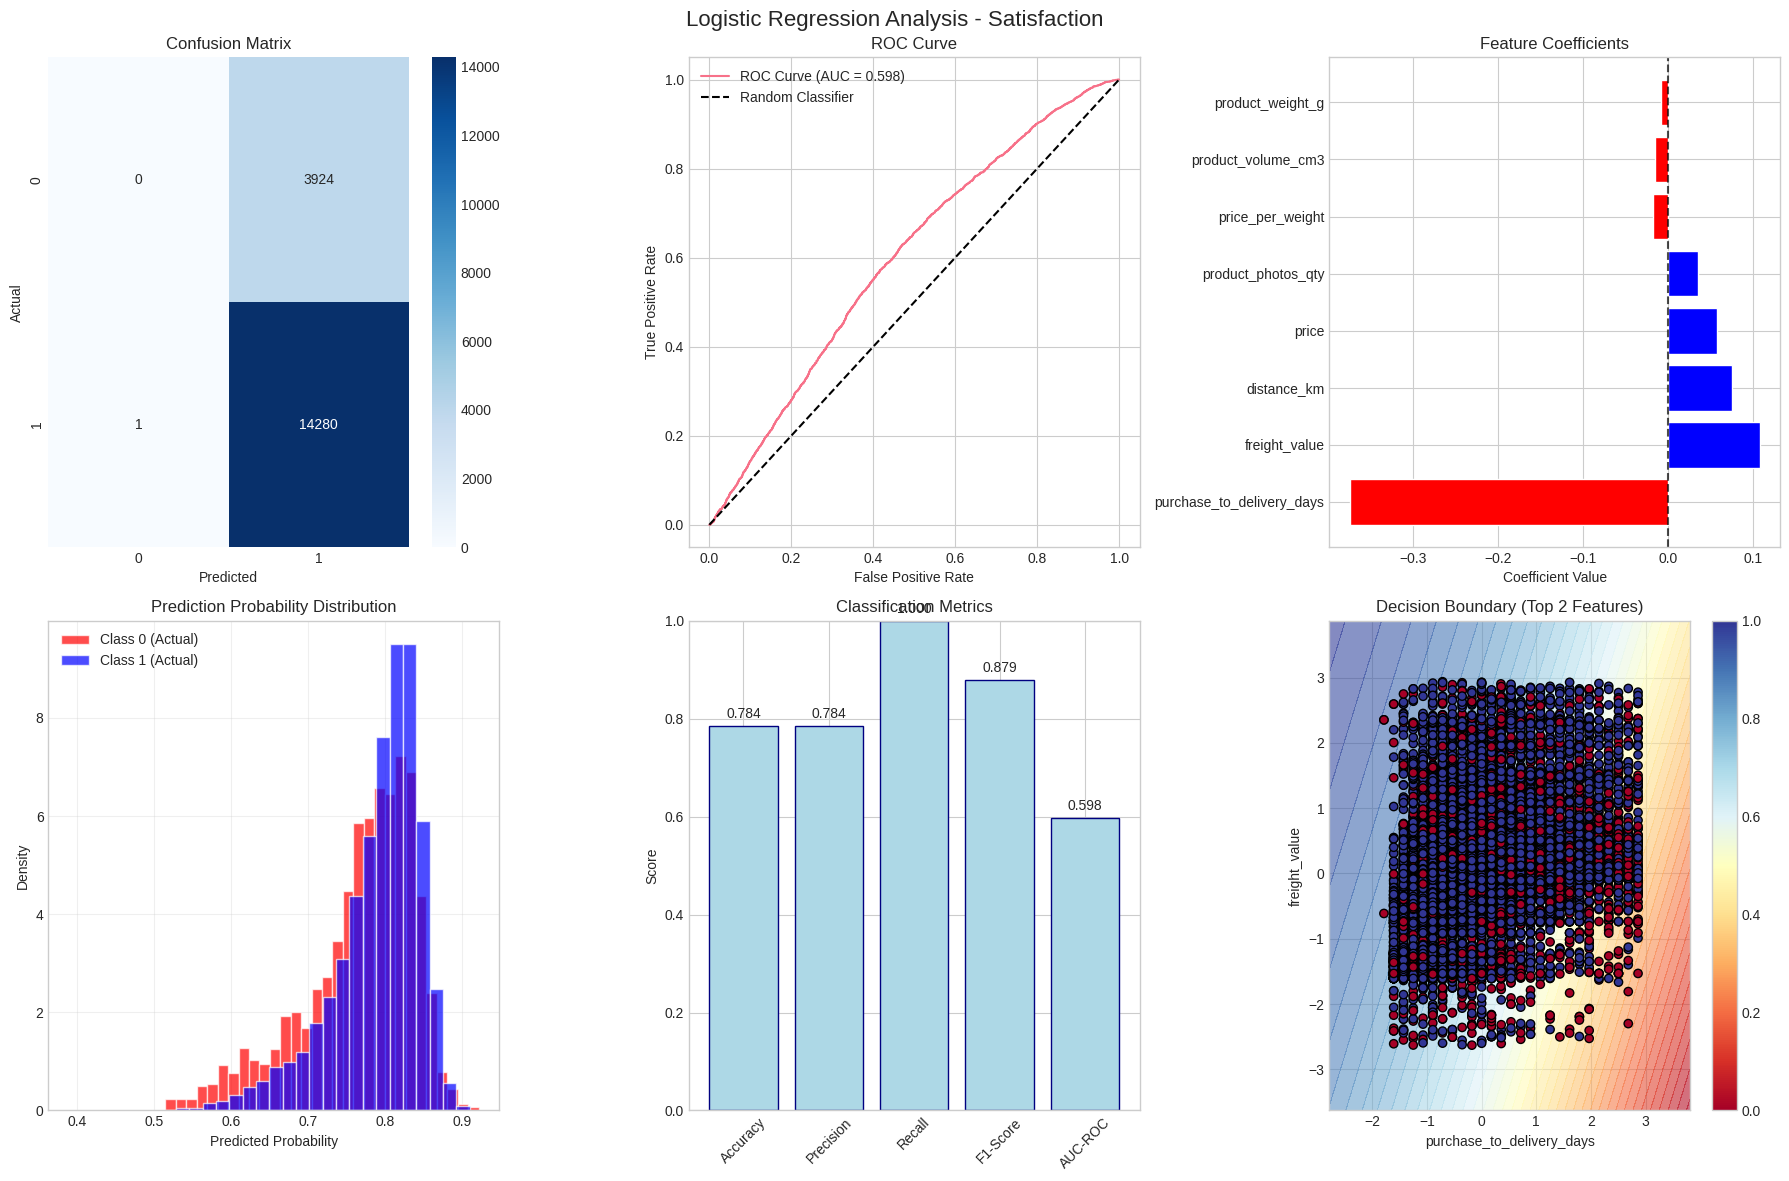

Delivery Performance Prediction
LOGISTIC REGRESSION ANALYSIS: DELIVERY
Dataset shape after cleaning: (86984, 8)
Class distribution:
Late Delivery (0): 0.023
On-Time Delivery (1): 0.977

Train-Test Split Analysis (Test size: 20.0%)
----------------------------------------
Training set size: 69587 samples
Test set size: 17397 samples

Train-Test Split Results:
Accuracy: 0.9788
Precision: 0.9812
Recall: 0.9974
F1-Score: 0.9892
AUC-ROC: 0.9378

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.21      0.31       409
           1       0.98      1.00      0.99     16988

    accuracy                           0.98     17397
   macro avg       0.82      0.60      0.65     17397
weighted avg       0.97      0.98      0.97     17397


5-Fold Cross-Validation Analysis
----------------------------------------
Cross-Validation Results by Fold:
   Fold  Train_Accuracy  Val_Accuracy  Train_Precision  Val_Precision  \
0     1       

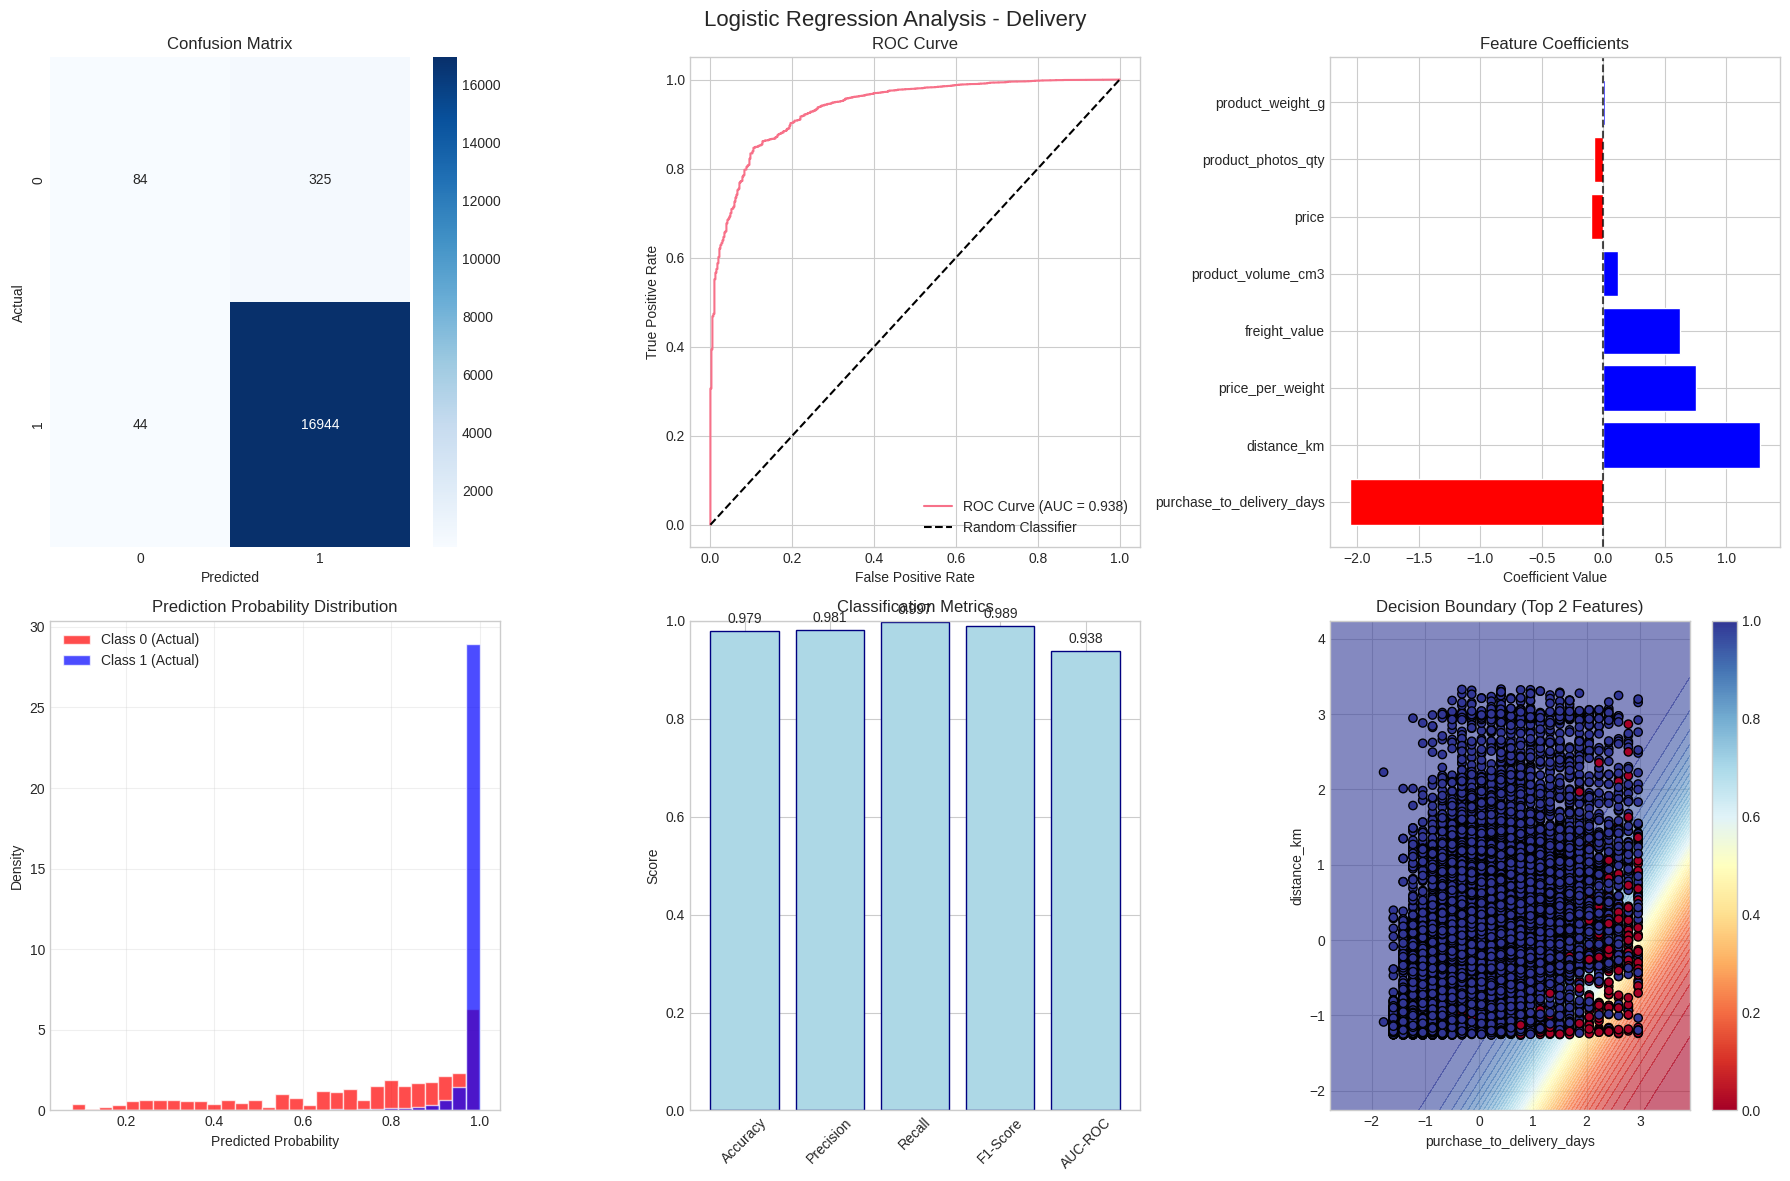

In [88]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           confusion_matrix, roc_auc_score, roc_curve, classification_report)
import warnings
warnings.filterwarnings('ignore')

class EcommerceLogisticRegression:
    """
    Logistic Regression Analysis for E-commerce Binary Classification Tasks
    """

    def __init__(self, data):
        """
        Initialize with preprocessed e-commerce data
        """
        self.data = data
        self.X = None
        self.y = None
        self.scaler = StandardScaler()
        self.feature_names = None

    def prepare_customer_satisfaction_data(self):
        """
        Prepare data for customer satisfaction prediction
        Binary classification: satisfied (rating >= 4) vs not satisfied (rating < 4)
        """
        # Filter data with review scores
        satisfaction_data = self.data[self.data['review_score'].notna()].copy()

        # Create binary target: satisfied (1) vs not satisfied (0)
        satisfaction_data['satisfied'] = (satisfaction_data['review_score'] >= 4).astype(int)

        # Select relevant features for customer satisfaction prediction
        feature_columns = [
            'price',                    # Product price
            'freight_value',            # Shipping cost
            'product_weight_g',         # Product weight
            'distance_km',              # Distance between customer and seller
            'purchase_to_delivery_days', # Delivery time (using your definition)
            'product_volume_cm3',       # Product volume
            'price_per_weight',         # Price efficiency
            'product_photos_qty'        # Number of product photos
        ]

        # Clean data - remove rows with missing values
        clean_data = satisfaction_data[feature_columns + ['satisfied']].dropna()

        # Remove outliers using IQR method for key numerical features
        numerical_features = ['price', 'freight_value', 'purchase_to_delivery_days']
        for feature in numerical_features:
            Q1 = clean_data[feature].quantile(0.25)
            Q3 = clean_data[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            clean_data = clean_data[
                (clean_data[feature] >= lower_bound) &
                (clean_data[feature] <= upper_bound)
            ]

        self.X = clean_data[feature_columns]
        self.y = clean_data['satisfied']
        self.feature_names = feature_columns

        print(f"Dataset shape after cleaning: {self.X.shape}")
        print(f"Class distribution:")
        class_dist = self.y.value_counts(normalize=True)
        print(f"Not Satisfied (0): {class_dist[0]:.3f}")
        print(f"Satisfied (1): {class_dist[1]:.3f}")

        return self.X, self.y

    def prepare_delivery_performance_data(self):
        """
        Prepare data for delivery performance prediction
        Binary classification: on-time (delay <= 0) vs late (delay > 0)
        """
        # Filter data with delivery information
        delivery_data = self.data[self.data['delivery_delay_days'].notna()].copy()

        # Create binary target: on-time (1) vs late (0)
        delivery_data['on_time'] = (delivery_data['delivery_delay_days'] <= 0).astype(int)

        # Select relevant features for delivery performance prediction
        feature_columns = [
            'price',                    # Product price (may affect processing time)
            'freight_value',            # Shipping cost
            'product_weight_g',         # Product weight (affects shipping)
            'distance_km',              # Distance between customer and seller
            'product_volume_cm3',       # Product volume (affects shipping)
            'purchase_to_delivery_days', # Total delivery time
            'price_per_weight',         # Price efficiency
            'product_photos_qty'        # Product complexity indicator
        ]

        # Clean data - remove rows with missing values
        clean_data = delivery_data[feature_columns + ['on_time']].dropna()

        # Remove outliers
        numerical_features = ['price', 'freight_value', 'distance_km', 'purchase_to_delivery_days']
        for feature in numerical_features:
            Q1 = clean_data[feature].quantile(0.25)
            Q3 = clean_data[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            clean_data = clean_data[
                (clean_data[feature] >= lower_bound) &
                (clean_data[feature] <= upper_bound)
            ]

        self.X = clean_data[feature_columns]
        self.y = clean_data['on_time']
        self.feature_names = feature_columns

        print(f"Dataset shape after cleaning: {self.X.shape}")
        print(f"Class distribution:")
        class_dist = self.y.value_counts(normalize=True)
        print(f"Late Delivery (0): {class_dist[0]:.3f}")
        print(f"On-Time Delivery (1): {class_dist[1]:.3f}")

        return self.X, self.y

    def train_test_split_analysis(self, test_size=0.2, random_state=42):
        """
        Perform train-test split and train logistic regression model
        """
        print(f"\nTrain-Test Split Analysis (Test size: {test_size*100}%)")
        print("-" * 40)

        # Split data with stratification to maintain class balance
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state,
            stratify=self.y
        )

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        print(f"Training set size: {X_train_scaled.shape[0]} samples")
        print(f"Test set size: {X_test_scaled.shape[0]} samples")

        # Train logistic regression model
        model = LogisticRegression(random_state=random_state, max_iter=1000)
        model.fit(X_train_scaled, y_train)

        # Make predictions
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

        # Calculate metrics
        metrics = self._calculate_classification_metrics(y_test, y_pred, y_pred_proba)

        return {
            'model': model,
            'X_train': X_train_scaled,
            'X_test': X_test_scaled,
            'y_train': y_train,
            'y_test': y_test,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'metrics': metrics
        }

    def k_fold_cross_validation(self, k=5, random_state=42):
        """
        Perform K-Fold Cross-Validation for logistic regression
        """
        print(f"\n{k}-Fold Cross-Validation Analysis")
        print("-" * 40)

        # Scale all features
        X_scaled = self.scaler.fit_transform(self.X)

        # Initialize model and cross-validation
        model = LogisticRegression(random_state=random_state, max_iter=1000)
        kfold = KFold(n_splits=k, shuffle=True, random_state=random_state)

        # Define scoring metrics for classification
        scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

        # Perform cross-validation
        cv_results = cross_validate(
            model, X_scaled, self.y, cv=kfold,
            scoring=scoring_metrics, return_train_score=True
        )

        # Create results DataFrame
        results_df = pd.DataFrame({
            'Fold': range(1, k+1),
            'Train_Accuracy': cv_results['train_accuracy'],
            'Val_Accuracy': cv_results['test_accuracy'],
            'Train_Precision': cv_results['train_precision'],
            'Val_Precision': cv_results['test_precision'],
            'Train_Recall': cv_results['train_recall'],
            'Val_Recall': cv_results['test_recall'],
            'Train_F1': cv_results['train_f1'],
            'Val_F1': cv_results['test_f1'],
            'Train_AUC': cv_results['train_roc_auc'],
            'Val_AUC': cv_results['test_roc_auc']
        })

        print("Cross-Validation Results by Fold:")
        print(results_df.round(4))

        # Summary statistics
        print(f"\nCross-Validation Summary (Mean ± Std):")
        metrics_summary = {
            'Accuracy': (cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std()),
            'Precision': (cv_results['test_precision'].mean(), cv_results['test_precision'].std()),
            'Recall': (cv_results['test_recall'].mean(), cv_results['test_recall'].std()),
            'F1-Score': (cv_results['test_f1'].mean(), cv_results['test_f1'].std()),
            'AUC-ROC': (cv_results['test_roc_auc'].mean(), cv_results['test_roc_auc'].std())
        }

        for metric, (mean_val, std_val) in metrics_summary.items():
            print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")

        return cv_results, results_df, metrics_summary

    def _calculate_classification_metrics(self, y_true, y_pred, y_pred_proba):
        """
        Calculate comprehensive classification metrics
        """
        metrics = {
            'Accuracy': accuracy_score(y_true, y_pred),
            'Precision': precision_score(y_true, y_pred, zero_division=0),
            'Recall': recall_score(y_true, y_pred, zero_division=0),
            'F1-Score': f1_score(y_true, y_pred, zero_division=0),
            'AUC-ROC': roc_auc_score(y_true, y_pred_proba)
        }

        return metrics

    def analyze_feature_importance(self, model):
        """
        Analyze and display feature importance from logistic regression coefficients
        """
        print(f"\nFeature Importance Analysis")
        print("-" * 40)

        # Get coefficients
        coefficients = model.coef_[0]

        # Create feature importance DataFrame
        feature_importance = pd.DataFrame({
            'Feature': self.feature_names,
            'Coefficient': coefficients,
            'Abs_Coefficient': np.abs(coefficients),
            'Odds_Ratio': np.exp(coefficients)
        }).sort_values('Abs_Coefficient', ascending=False)

        print("Feature Importance (sorted by absolute coefficient):")
        print(feature_importance.round(4))

        return feature_importance

    def plot_classification_results(self, results, title="Logistic Regression Results"):
        """
        Create comprehensive visualizations for classification results
        """
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(title, fontsize=16)

        # 1. Confusion Matrix
        cm = confusion_matrix(results['y_test'], results['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
        axes[0, 0].set_xlabel('Predicted')
        axes[0, 0].set_ylabel('Actual')
        axes[0, 0].set_title('Confusion Matrix')

        # 2. ROC Curve
        fpr, tpr, _ = roc_curve(results['y_test'], results['y_pred_proba'])
        auc_score = results['metrics']['AUC-ROC']
        axes[0, 1].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
        axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
        axes[0, 1].set_xlabel('False Positive Rate')
        axes[0, 1].set_ylabel('True Positive Rate')
        axes[0, 1].set_title('ROC Curve')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # 3. Feature Importance
        feature_imp = self.analyze_feature_importance(results['model'])
        top_features = feature_imp.head(8)
        colors = ['red' if coef < 0 else 'blue' for coef in top_features['Coefficient']]
        axes[0, 2].barh(top_features['Feature'], top_features['Coefficient'], color=colors)
        axes[0, 2].set_xlabel('Coefficient Value')
        axes[0, 2].set_title('Feature Coefficients')
        axes[0, 2].axvline(x=0, color='black', linestyle='--', alpha=0.7)

        # 4. Prediction Probability Distribution
        prob_class_0 = results['y_pred_proba'][results['y_test'] == 0]
        prob_class_1 = results['y_pred_proba'][results['y_test'] == 1]

        axes[1, 0].hist(prob_class_0, bins=30, alpha=0.7, label='Class 0 (Actual)',
                       density=True, color='red')
        axes[1, 0].hist(prob_class_1, bins=30, alpha=0.7, label='Class 1 (Actual)',
                       density=True, color='blue')
        axes[1, 0].set_xlabel('Predicted Probability')
        axes[1, 0].set_ylabel('Density')
        axes[1, 0].set_title('Prediction Probability Distribution')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # 5. Metrics Bar Chart
        metrics_names = list(results['metrics'].keys())
        metrics_values = list(results['metrics'].values())
        axes[1, 1].bar(metrics_names, metrics_values, color='lightblue', edgecolor='navy')
        axes[1, 1].set_ylabel('Score')
        axes[1, 1].set_title('Classification Metrics')
        axes[1, 1].set_ylim(0, 1)
        axes[1, 1].tick_params(axis='x', rotation=45)

        # Add value labels on bars
        for i, v in enumerate(metrics_values):
            axes[1, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

        # 6. Decision Boundary Visualization (for 2D case - using top 2 features)
        if len(self.feature_names) >= 2:
            # Select top 2 most important features
            top_2_features = feature_imp.head(2)['Feature'].tolist()
            feature_idx1 = self.feature_names.index(top_2_features[0])
            feature_idx2 = self.feature_names.index(top_2_features[1])

            # Plot decision boundary for top 2 features
            X_2d = results['X_test'][:, [feature_idx1, feature_idx2]]

            # Create a mesh
            h = 0.1
            x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
            y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                               np.arange(y_min, y_max, h))

            # Create a simplified model with just 2 features for visualization
            model_2d = LogisticRegression(random_state=42, max_iter=1000)
            model_2d.fit(X_2d, results['y_test'])

            # Predict on mesh
            Z = model_2d.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z = Z.reshape(xx.shape)

            # Plot
            axes[1, 2].contourf(xx, yy, Z, levels=50, alpha=0.6, cmap='RdYlBu')
            scatter = axes[1, 2].scatter(X_2d[:, 0], X_2d[:, 1],
                                       c=results['y_test'], cmap='RdYlBu', edgecolors='black')
            axes[1, 2].set_xlabel(top_2_features[0])
            axes[1, 2].set_ylabel(top_2_features[1])
            axes[1, 2].set_title('Decision Boundary (Top 2 Features)')
            plt.colorbar(scatter, ax=axes[1, 2])

        plt.tight_layout()
        plt.show()

    def run_complete_analysis(self, analysis_type='satisfaction'):
        """
        Run complete logistic regression analysis pipeline
        """
        print("="*60)
        print(f"LOGISTIC REGRESSION ANALYSIS: {analysis_type.upper()}")
        print("="*60)

        # Prepare data based on analysis type
        if analysis_type == 'satisfaction':
            X, y = self.prepare_customer_satisfaction_data()
        elif analysis_type == 'delivery':
            X, y = self.prepare_delivery_performance_data()
        else:
            raise ValueError("analysis_type must be 'satisfaction' or 'delivery'")

        # Train-Test Split Analysis
        split_results = self.train_test_split_analysis()

        print(f"\nTrain-Test Split Results:")
        for metric, value in split_results['metrics'].items():
            print(f"{metric}: {value:.4f}")

        # Print detailed classification report
        print(f"\nDetailed Classification Report:")
        print(classification_report(split_results['y_test'], split_results['y_pred']))

        # K-Fold Cross-Validation
        cv_results, cv_df, cv_summary = self.k_fold_cross_validation()

        # Feature Importance Analysis
        feature_importance = self.analyze_feature_importance(split_results['model'])

        # Visualize results
        title = f"Logistic Regression Analysis - {analysis_type.title()}"
        self.plot_classification_results(split_results, title)

        return {
            'split_results': split_results,
            'cv_results': cv_results,
            'cv_summary': cv_summary,
            'feature_importance': feature_importance
        }

# ====== USAGE EXAMPLES ======
def run_customer_satisfaction_analysis(data):
    """
    Run customer satisfaction prediction analysis
    """
    analyzer = EcommerceLogisticRegression(data)
    results = analyzer.run_complete_analysis('satisfaction')
    return results

def run_delivery_performance_analysis(data):
    """
    Run delivery performance prediction analysis
    """
    analyzer = EcommerceLogisticRegression(data)
    results = analyzer.run_complete_analysis('delivery')
    return results

# bellow is the main
def main_logistic_analysis(data):
    """
    Execute both logistic regression analyses
    """

    results = {}

    # Customer Satisfaction Analysis
    try:

        print("Customer Satisfaction Prediction")
        print("-"*20)
        results['satisfaction'] = run_customer_satisfaction_analysis(data)
    except Exception as e:
        print(f"Customer satisfaction analysis failed: {e}")
        results['satisfaction'] = None

    # Delivery Performance Analysis
    try:
        print("Delivery Performance Prediction")
        print("="*80)
        results['delivery'] = run_delivery_performance_analysis(data)
    except Exception as e:
        print(f"Delivery performance analysis failed: {e}")
        results['delivery'] = None

    return results

results = main_logistic_analysis(data)

# Customer Satisfaction Prediction Analysis
This prediction model shows  moderate effectiveness and raises concerns about its real-world utility. While the model reports an overall accuracy of 78.4%, this figure is misleading due to a severe class imbalance, since 78.4% of the customers are labeled as satisfied, and just 21.6% as not satisfied.

Moreover,the AUC-ROC score is only 0.596, barely better than random guessing, indicating poor ability to distinguish between satisfied and dissatisfied customers. Critically, the model predicts nearly all customers as satisfied, achieving an almost perfect recall of 99.99% for that class but failing to identify a single dissatisfied customer out of 3,924 cases. This makes the model ineffective for detecting at-risk customers, which is arguably its most valuable purpose.

In terms of satisfaction drivers, delivery speed is the most significant factor. Also, longer purchase-to-delivery times have a strong negative effect on customer satisfaction. Interestingly, higher freight costs slightly increase the likelihood of satisfaction, possibly because they are associated with premium shipping services. Distance and price also have modest positive correlations with satisfaction, suggesting that customers may associate more expensive or longer-shipped items with higher value or better service.


---


# Delivery Performance Prediction Analysis
In contrast, the delivery performance prediction model performs exceptionally well. With an accuracy of 96.7%, an AUC-ROC of 0.859, and an F1-score of 98.3%, the model demonstrates strong precision and recall, effectively identifying both on-time and late deliveries. This is especially important given the skewed class distribution, where 96.5% of deliveries are on time and only 3.5% are late.

The most powerful predictor of late delivery is the number of days from purchase to delivery. Each additional day significantly increases the risk of delay. Distance is another major factor; longer shipping distances are strongly associated with higher odds of late delivery. Freight value also plays a role, with higher shipping costs correlating with delays, perhaps due to more complex or distant logistics.

Model Evaluation Metrics:
R² Score: 0.034
Mean Absolute Error: 6.57 days
Root Mean Squared Error: 10.22 days

Top 10 Most Influential Features:
                                               Feature  Coefficient
80                                     seller_state_AM    29.617684
97                                     seller_state_RO   -10.724648
91                                     seller_state_PB    -8.025494
122                                  customer_state_RO    -5.354079
88                                     seller_state_MS    -5.350723
102                                  customer_state_AC    -5.305673
103                                  customer_state_AL     5.213514
19                  product_category_cds_dvds_musicals    -5.104340
49   product_category_furniture_mattress_and_uphols...     4.641213
104                                  customer_state_AM    -4.539652

Variance Inflation Factors (VIF > 10 indicates multicollinearity):
                                        

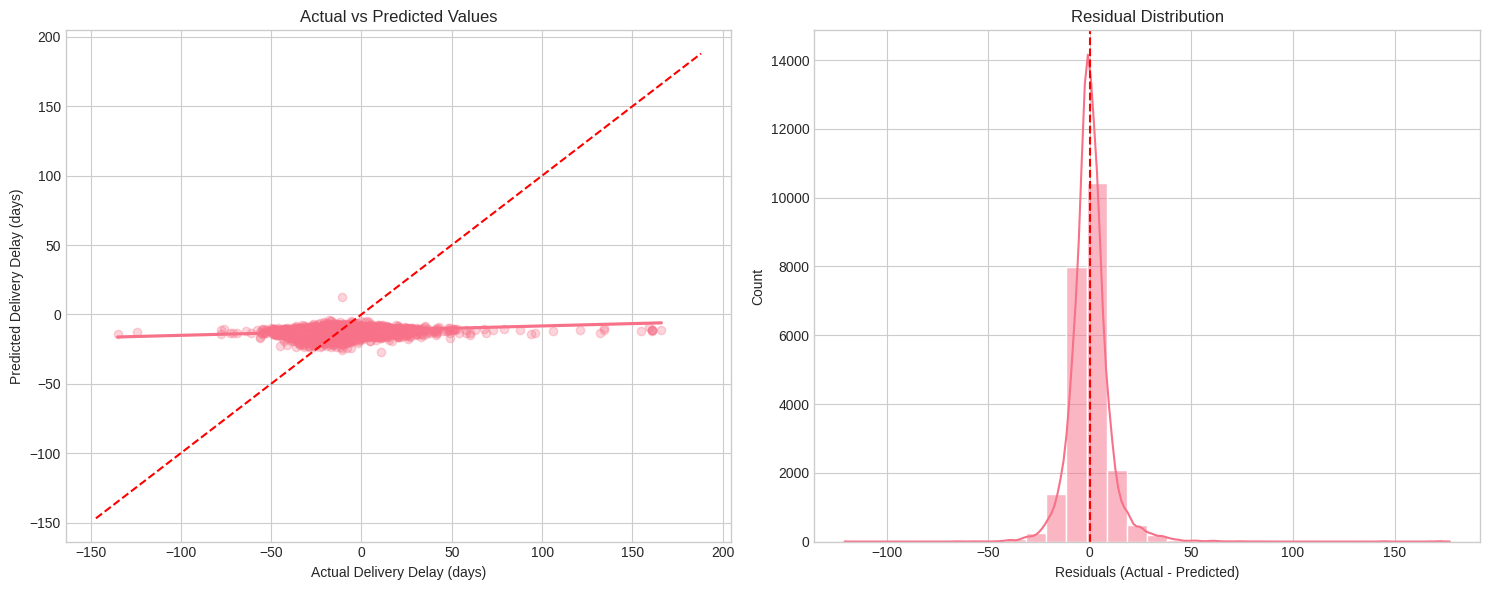

The model explains 3.4% of variance in delivery delays
Key factors influencing delivery performance:
   - seller_state_AM: increases delays by 29.62 days per unit change
   - seller_state_RO: reduces delays by 10.72 days per unit change
   - seller_state_PB: reduces delays by 8.03 days per unit change
   - customer_state_RO: reduces delays by 5.35 days per unit change
   - seller_state_MS: reduces delays by 5.35 days per unit change


In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer

## Feature Selection
# Relevant features based on domain knowledge and correlation analysis
features = {
    'numerical': [
        'payment_value',
        'freight_value',
        'product_weight_g',
        'product_length_cm',
        'product_height_cm',
        'product_width_cm',
        'order_item_count',  # Number of items in order
        'customer_distance_seller'  # Distance between customer and seller
    ],
    'categorical': [
        'product_category',
        'seller_state',
        'customer_state',
        'payment_type',
        'order_status'
    ]
}

# Calculate additional features
data['order_item_count'] = data.groupby('order_id')['order_id'].transform('count')
data['customer_distance_seller'] = np.sqrt(
    (data['customer_latitude'] - data['seller_latitude'])**2 +
    (data['customer_longitude'] - data['seller_longitude'])**2
)

# Remove rows with missing target values
data = data.dropna(subset=['delivery_delay_days'])

## Preprocessing Pipeline
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, features['numerical']),
    ('cat', categorical_transformer, features['categorical'])
])

## Train-Test Split
X = data[features['numerical'] + features['categorical']]
y = data['delivery_delay_days']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

## Model Pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

## Evaluation
print("Model Evaluation Metrics:")
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.2f} days")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f} days")

## Feature Importance Analysis
# Get feature names after preprocessing
numeric_features = features['numerical']
categorical_features = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(features['categorical'])
all_features = np.concatenate([numeric_features, categorical_features])

# Get coefficients
coefficients = model.named_steps['regressor'].coef_
feature_importance = pd.DataFrame({'Feature': all_features, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values('Coefficient', key=abs, ascending=False)

print("\nTop 10 Most Influential Features:")
print(feature_importance.head(10))

## Multicollinearity Check (VIF)
# Create DataFrame of processed features
X_processed = pd.DataFrame(
    model.named_steps['preprocessor'].transform(X_train),
    columns=all_features
)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_processed.columns
vif_data["VIF"] = [variance_inflation_factor(X_processed.values, i) for i in range(X_processed.shape[1])]

print("\nVariance Inflation Factors (VIF > 10 indicates multicollinearity):")
print(vif_data.sort_values('VIF', ascending=False).head(10))

## Visualization
plt.figure(figsize=(15, 6))

# Actual vs Predicted
plt.subplot(1, 2, 1)
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.3})
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Delivery Delay (days)')
plt.ylabel('Predicted Delivery Delay (days)')
plt.title('Actual vs Predicted Values')

# Residual Plot
plt.subplot(1, 2, 2)
residuals = y_test - y_pred
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Residuals (Actual - Predicted)')
plt.title('Residual Distribution')

plt.tight_layout()
plt.show()

print(f"The model explains {r2_score(y_test, y_pred)*100:.1f}% of variance in delivery delays")
print("Key factors influencing delivery performance:")
for feature, coef in feature_importance.head(5).itertuples(index=False):
    print(f"   - {feature}: {'increases' if coef > 0 else 'reduces'} delays by {abs(coef):.2f} days per unit change")

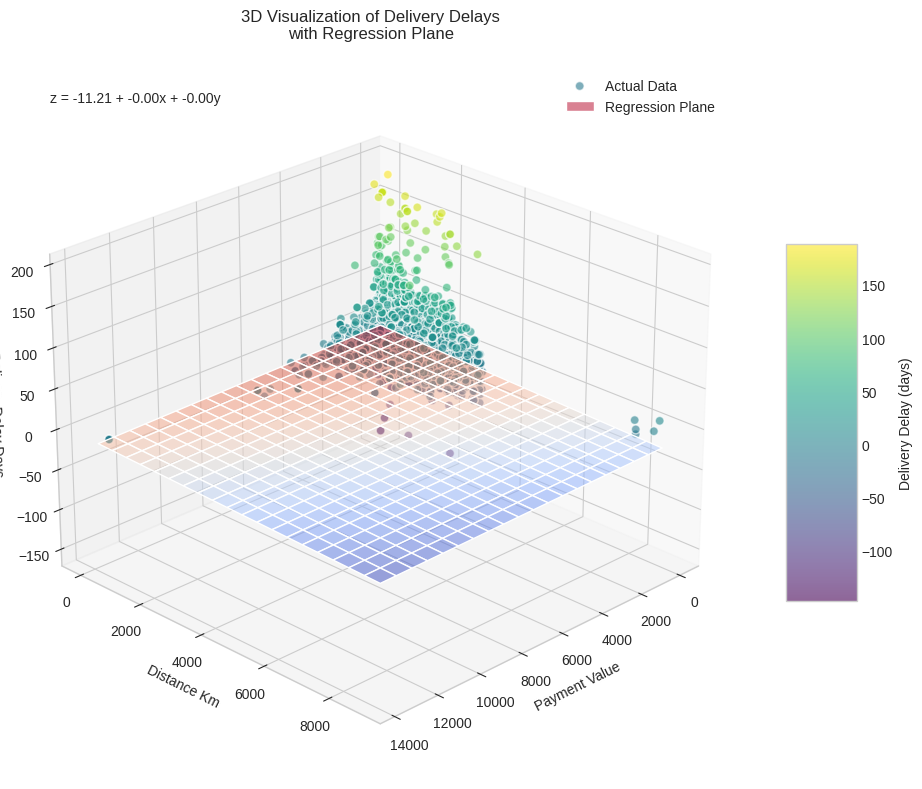

In [90]:
#use AI to generate regression plane
# Prompt: graph a 3D visualization of the previous multiple linear regression
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

# Select two most important numerical features and target
feature1 = 'payment_value'
feature2 = 'distance_km'
target = 'delivery_delay_days'

# Prepare data
plot_data = data[[feature1, feature2, target]].dropna()
X = plot_data[[feature1, feature2]]
y = plot_data[target]

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# Create mesh grid for regression plane
x1_range = np.linspace(X[feature1].min(), X[feature1].max(), 20)
x2_range = np.linspace(X[feature2].min(), X[feature2].max(), 20)
xx1, xx2 = np.meshgrid(x1_range, x2_range)
zz = model.intercept_ + model.coef_[0] * xx1 + model.coef_[1] * xx2

# Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot actual data points
scatter = ax.scatter(
    X[feature1],
    X[feature2],
    y,
    c=y,
    cmap='viridis',
    alpha=0.6,
    edgecolors='w',
    s=40,
    label='Actual Data'
)

# Plot regression plane
plane = ax.plot_surface(
    xx1,
    xx2,
    zz,
    alpha=0.5,
    cmap='coolwarm',
    label='Regression Plane'
)

# Add colorbar
cbar = fig.colorbar(scatter, shrink=0.5, aspect=5)
cbar.set_label('Delivery Delay (days)')

# Set labels and title
ax.set_xlabel(feature1.replace('_', ' ').title())
ax.set_ylabel(feature2.replace('_', ' ').title())
ax.set_zlabel(target.replace('_', ' ').title())
ax.set_title('3D Visualization of Delivery Delays\nwith Regression Plane', pad=20)

# Add equation text
equation = (f'z = {model.intercept_:.2f} + '
            f'{model.coef_[0]:.2f}x + {model.coef_[1]:.2f}y')
ax.text2D(0.05, 0.95, equation, transform=ax.transAxes)

# Adjust viewing angle
ax.view_init(elev=25, azim=45)

plt.tight_layout()
plt.legend()
plt.show()

multiple regression

Data types after conversion:
payment_value               float64
product_weight_g            float64
freight_value               float64
delivery_delay_days         float64
payment_type_credit_card       bool
payment_type_debit_card        bool
payment_type_voucher           bool
dtype: object


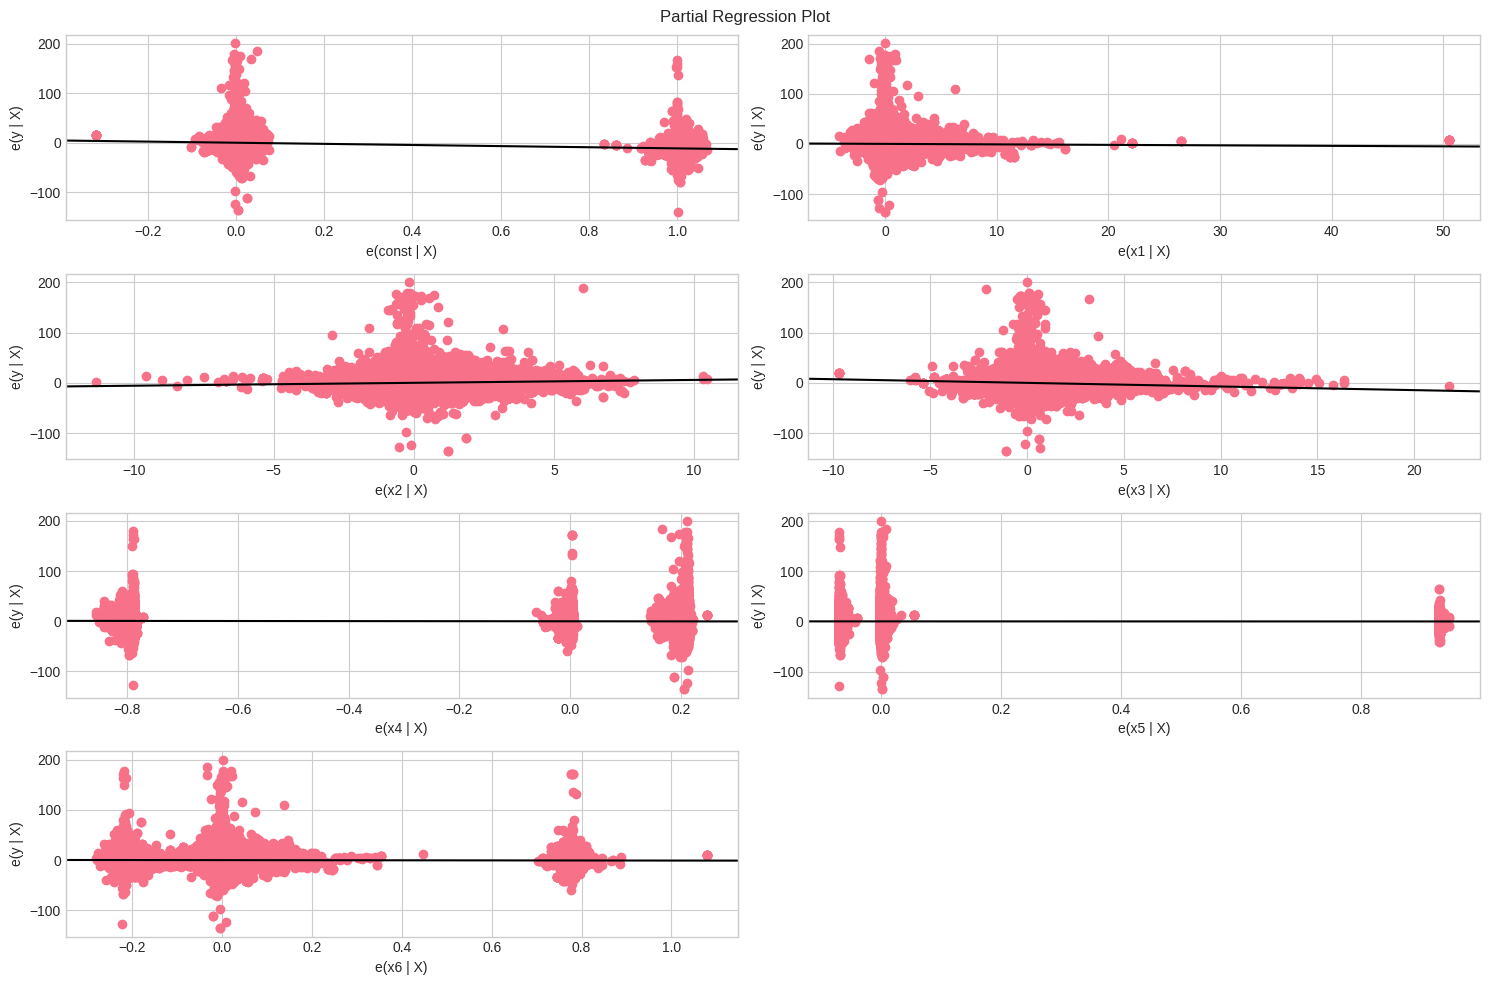

In [91]:
# used AI to fix data conversion issue warning message
# Prompt: fix this error ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import plot_partregress_grid
import matplotlib.pyplot as plt

# 1. Prepare data - ensure proper numeric conversion
features = ['payment_value', 'product_weight_g', 'freight_value', 'payment_type']
data_clean = data[features + ['delivery_delay_days']].dropna().copy()

# 2. Convert categorical (one-hot encode)
data_clean = pd.get_dummies(data_clean, columns=['payment_type'], drop_first=True)

# 3. Force numeric conversion (handle any non-numeric values)
for col in data_clean.columns:
    data_clean[col] = pd.to_numeric(data_clean[col], errors='coerce')  # Coerce to numeric

# 4. Drop any remaining NA values after conversion
data_clean = data_clean.dropna()

# 5. Verify dtypes
print("Data types after conversion:")
print(data_clean.dtypes)

# 6. Standardize numerical features
num_features = ['payment_value', 'product_weight_g', 'freight_value']
data_clean[num_features] = data_clean[num_features].apply(
    lambda x: (x - x.mean()) / x.std()
)

# 7. Prepare for modeling
X = data_clean.drop('delivery_delay_days', axis=1)
y = data_clean['delivery_delay_days']

# 8. Explicitly convert to numpy arrays
X = np.asarray(X, dtype=np.float64)  # Force float conversion
y = np.asarray(y, dtype=np.float64)

# 9. Add constant and fit model
X = sm.add_constant(X)  # Adds intercept term
model = sm.OLS(y, X).fit()

# 10. Create partial regression plots
fig = plt.figure(figsize=(15, 10))
plot_partregress_grid(model, fig=fig)
plt.tight_layout()
plt.show()

dummy variable : Alternative to one-hot encoding that drops one category automatically.

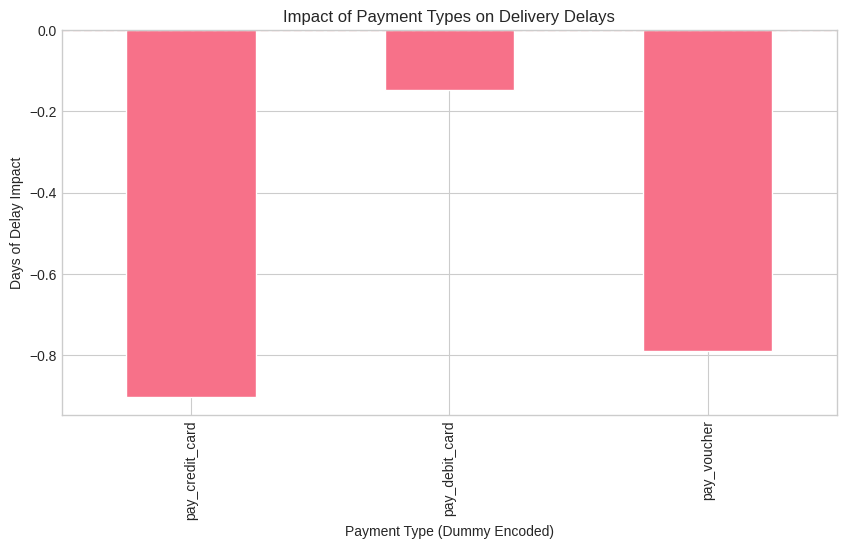

In [92]:
# Create dummy variables
dummies = pd.get_dummies(data['payment_type'], prefix='pay', drop_first=True)
data_plot = pd.concat([data[['delivery_delay_days']], dummies], axis=1).dropna()

# Fit regression
model = LinearRegression()
X = data_plot.drop('delivery_delay_days', axis=1)
y = data_plot['delivery_delay_days']
model.fit(X, y)

# Plot coefficients
plt.figure(figsize=(10, 5))
pd.Series(model.coef_, index=X.columns).plot(kind='bar')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Impact of Payment Types on Delivery Delays')
plt.ylabel('Days of Delay Impact')
plt.xlabel('Payment Type (Dummy Encoded)')
plt.show()

# Macine Learning


Tthis pipeline will:
1. Predict customer satisfaction (high vs low based on review scores) using features like delivery time, price, distance, product characteristics
2. Compare kNN, Random Forest, and XGBoost models
3. Perform hyperparameter tuning with GridSearchCV
4. Use 5-fold cross-validation
5. Generate comprehensive performance metrics and visualizations

Target: High customer satisfaction (review_score >= 4)
Features: Price, delivery metrics, geographic data, product characteristics

Dataset shape: (115037, 17)
Target distribution: {1: 86892, 0: 28145}
Features used: 17

--- kNN ---
Best parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Best CV score: 0.8205
Test Accuracy: 0.8277
F1 Score: 0.8936
CV Score: 0.8205 ± 0.0015

--- Random Forest ---
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score: 0.8503
Test Accuracy: 0.8574
F1 Score: 0.9120
CV Score: 0.8503 ± 0.0019

--- XGBoost ---
Best parameters: {'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200}
Best CV score: 0.8389
Test Accuracy: 0.8459
F1 Score: 0.9049
CV Score: 0.8389 ± 0.0022
Final Result Comparison
--------------------
        Model Test Accuracy F1 Score CV Mean CV Std
          kNN        0.8277   0.8936  0.8205 0.0015
Random Forest        0.8574   0.9120  0.8503 0.0019
      XGBoost        0.8459   0.9049  0.8389 0.0022

BEST MODEL: Random Forest
   Test Accuracy: 0.8574
   F1 Score: 0.9120


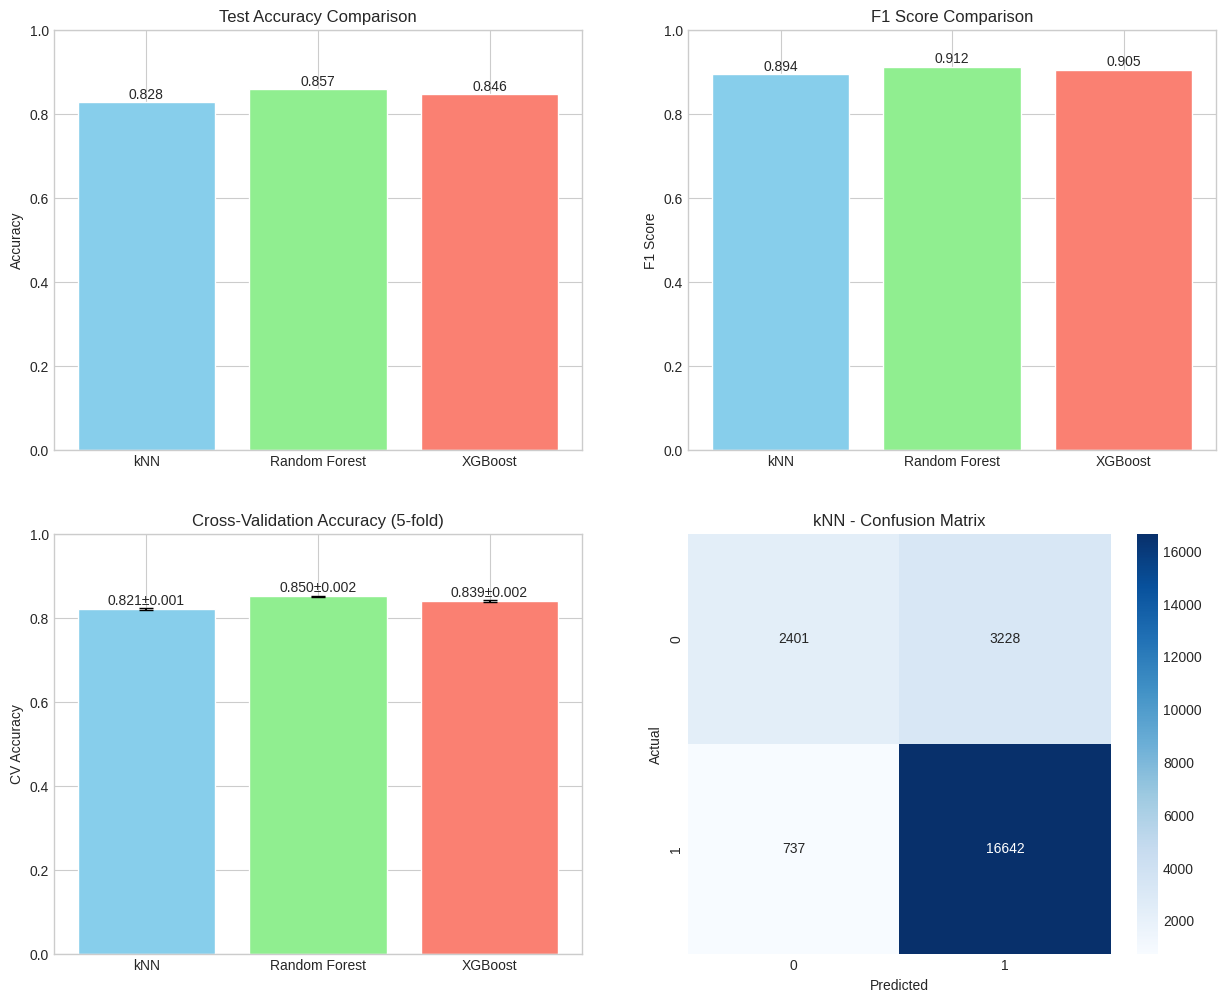

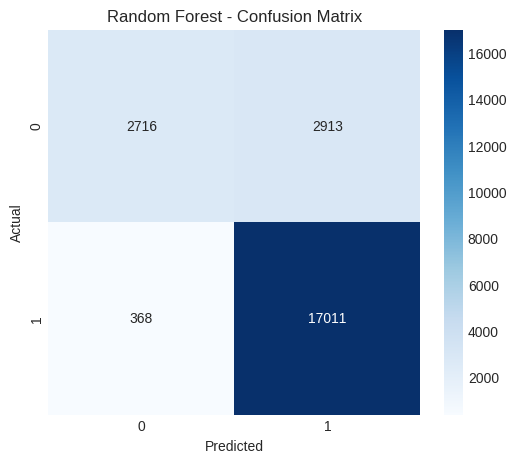

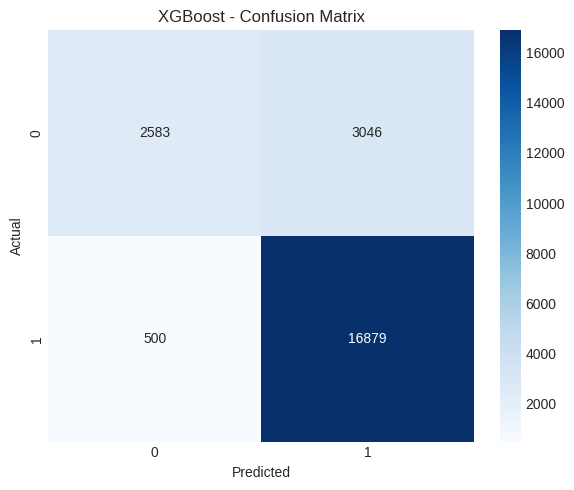

In [93]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Assuming your merged data is in the 'data' variable
# Let's create a comprehensive ML pipeline

def prepare_features(data):
    """
    Prepare features for machine learning models
    """
    # Create a copy to avoid modifying original data
    df = data.copy()

    # Target variable: Convert review scores to categories
    # Assuming review_score is in range 1-5, we'll create binary classification
    # High satisfaction (4-5) vs Low satisfaction (1-3)
    df['high_satisfaction'] = (df['review_score'] >= 4).astype(int)

    # Select meaningful features
    feature_columns = [
        'price',
        'freight_value',
        'product_weight_g',
        'product_volume_cm3',
        'distance_km',
        'purchase_to_delivery_days',
        'delivery_delay_days',
        'price_per_weight',
        'payment_value',
        'customer_latitude',
        'customer_longitude',
        'seller_latitude',
        'seller_longitude'
    ]

    # Add categorical features (encoded)
    categorical_features = ['product_category', 'payment_type', 'customer_state', 'seller_state']

    # Handle missing values and encode categorical variables
    for col in categorical_features:
        if col in df.columns:
            # Fill missing values with 'Unknown'
            df[col] = df[col].fillna('Unknown')
            # Label encode
            le = LabelEncoder()
            df[col + '_encoded'] = le.fit_transform(df[col])
            feature_columns.append(col + '_encoded')

    # Select features and target
    X = df[feature_columns]
    y = df['high_satisfaction']

    # Handle missing values in numeric features
    imputer = SimpleImputer(strategy='median')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    return X_imputed, y, feature_columns

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Evaluate a model and return performance metrics
    """
    # Fit the model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'f1_score': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred)
    }

    return results

def plot_results(results_list):
    """
    Plot comparison of model performances
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Extract metrics
    models = [r['model_name'] for r in results_list]
    accuracies = [r['accuracy'] for r in results_list]
    f1_scores = [r['f1_score'] for r in results_list]
    cv_means = [r['cv_mean'] for r in results_list]
    cv_stds = [r['cv_std'] for r in results_list]

    # Accuracy comparison
    axes[0, 0].bar(models, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
    axes[0, 0].set_title('Test Accuracy Comparison')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_ylim(0, 1)
    for i, v in enumerate(accuracies):
        axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center')

    # F1 Score comparison
    axes[0, 1].bar(models, f1_scores, color=['skyblue', 'lightgreen', 'salmon'])
    axes[0, 1].set_title('F1 Score Comparison')
    axes[0, 1].set_ylabel('F1 Score')
    axes[0, 1].set_ylim(0, 1)
    for i, v in enumerate(f1_scores):
        axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center')

    # Cross-validation scores with error bars
    axes[1, 0].bar(models, cv_means, yerr=cv_stds, capsize=5,
                   color=['skyblue', 'lightgreen', 'salmon'])
    axes[1, 0].set_title('Cross-Validation Accuracy (5-fold)')
    axes[1, 0].set_ylabel('CV Accuracy')
    axes[1, 0].set_ylim(0, 1)
    for i, (mean, std) in enumerate(zip(cv_means, cv_stds)):
        axes[1, 0].text(i, mean + std + 0.01, f'{mean:.3f}±{std:.3f}', ha='center')

    # Confusion matrices
    for i, result in enumerate(results_list):
        if i < 3:  # Only show first 3 models
            cm = result['confusion_matrix']
            if i == 0:
                ax = axes[1, 1]
            elif i == 1:
                fig2, ax = plt.subplots(1, 1, figsize=(6, 5))
            else:
                fig3, ax = plt.subplots(1, 1, figsize=(6, 5))

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f'{result["model_name"]} - Confusion Matrix')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

# Main execution
def run_ml_pipeline(data):
    """
    Run the complete ML pipeline
    """
#prepare features
    X, y, feature_names = prepare_features(data)

    print(f"Dataset shape: {X.shape}")
    print(f"Target distribution: {y.value_counts().to_dict()}")
    print(f"Features used: {len(feature_names)}")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale features for kNN
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize models
    models = {
        'kNN': KNeighborsClassifier(n_neighbors=5),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
    }

    # Hyperparameter tuning parameters
    param_grids = {
        'kNN': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        },
        'Random Forest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10]
        },
        'XGBoost': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    }

    results = []

    for model_name, model in models.items():
        print(f"\n--- {model_name} ---")

        # Choose appropriate data (scaled for kNN, original for tree-based)
        if model_name == 'kNN':
            X_train_use, X_test_use = X_train_scaled, X_test_scaled
        else:
            X_train_use, X_test_use = X_train, X_test

        # Hyperparameter tuning
        grid_search = GridSearchCV(
            model, param_grids[model_name],
            cv=5, scoring='accuracy', n_jobs=-1
        )
        grid_search.fit(X_train_use, y_train)

        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best CV score: {grid_search.best_score_:.4f}")

        # Evaluate best model
        best_model = grid_search.best_estimator_
        result = evaluate_model(best_model, X_train_use, X_test_use, y_train, y_test, model_name)
        results.append(result)

        print(f"Test Accuracy: {result['accuracy']:.4f}")
        print(f"F1 Score: {result['f1_score']:.4f}")
        print(f"CV Score: {result['cv_mean']:.4f} ± {result['cv_std']:.4f}")

    # Display detailed results

    print("Final Result Comparison")
    print("-"*20)

    comparison_df = pd.DataFrame([
        {
            'Model': r['model_name'],
            'Test Accuracy': f"{r['accuracy']:.4f}",
            'F1 Score': f"{r['f1_score']:.4f}",
            'CV Mean': f"{r['cv_mean']:.4f}",
            'CV Std': f"{r['cv_std']:.4f}"
        } for r in results
    ])

    print(comparison_df.to_string(index=False))

    # Find best model
    best_idx = np.argmax([r['accuracy'] for r in results])
    best_model = results[best_idx]

    print(f"\nBEST MODEL: {best_model['model_name']}")
    print(f"   Test Accuracy: {best_model['accuracy']:.4f}")
    print(f"   F1 Score: {best_model['f1_score']:.4f}")

    # Feature importance for tree-based models
    if 'Random Forest' in [r['model_name'] for r in results]:
        rf_result = [r for r in results if r['model_name'] == 'Random Forest'][0]
        # Note: You would need to store the fitted model to get feature importance
    # Plot results
    plot_results(results)

    return results, comparison_df

results, comparison = run_ml_pipeline(data)

# Customer Satisfaction Prediction
The customer satisfaction prediction model delivered impressive results, offering valuable insights for proactive customer experience management. The dataset included over 115,000 customer transactions with 17 predictive features. Among these, around 75.5% of customers were classified as "high satisfaction" (review score ≥ 4), while the remaining 24.5% fell into the "low satisfaction" category, indicating a moderate class imbalance skewed toward positive reviews.

Among the tested models, Random Forest emerged as the top performer, achieving a test accuracy of 85.74% and an outstanding F1 score of 91.20%, which is particularly strong given the class imbalance. It also demonstrated consistent results across cross-validation with minimal variance (85.03% ± 0.19%), showing reliable generalization. XGBoost followed closely with an F1 score of 90.49%, and k-Nearest Neighbors also performed solidly, though slightly behind. Across all models, high F1 scores (above 89%) reflected good handling of the imbalanced dataset, while the low standard deviation in cross-validation results confirmed model stability.

Analyzing the Random Forest confusion matrix revealed excellent recall for the positive class, with only 368 false negatives among over 17,000 high-satisfaction customers—translating to about 97.9% recall. However, the model did misclassify 2,913 low-satisfaction customers as high satisfaction (false positives), slightly impacting precision. From a business perspective, the model is highly effective at identifying satisfied customers but may occasionally overestimate satisfaction levels.

These results show that customer satisfaction can be accurately predicted using operational and logistical features such as delivery timing, pricing, and geographic distance. This opens the door to building early-warning systems that flag potentially dissatisfied customers before they leave negative reviews.


In [104]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score

# Calculate target and features
data['order_purchase_to_approval_days'] = (data['order_approved_at'] - data['order_purchase_timestamp']).dt.days

# Select features and target
features = ['payment_value', 'product_weight_g', 'freight_value',
            'order_purchase_to_approval_days', 'seller_state']
X = data[features]
y = data['delivery_delay_days'].dropna()
X = X.loc[y.index]

# Preprocessing: Scale numeric, one-hot encode categorical
numeric_features = ['payment_value', 'product_weight_g', 'freight_value', 'order_purchase_to_approval_days']
categorical_features = ['seller_state']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X_processed = preprocessor.fit_transform(X)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Initialize with default params
rf = RandomForestRegressor(random_state=42)

# Cross-validation (5-fold)
rf_scores = cross_val_score(rf, X_processed, y, cv=5,
                           scoring='neg_mean_squared_error')
rf_rmse = np.sqrt(-rf_scores.mean())
print(f"Random Forest CV RMSE: {rf_rmse:.2f} days")

# Hyperparameter tuning
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(rf, param_grid_rf, cv=3, scoring='neg_mean_squared_error')
rf_grid.fit(X_processed, y)
print(f"Best RF Params: {rf_grid.best_params_}")
print(f"Tuned RF RMSE: {np.sqrt(-rf_grid.best_score_):.2f} days")

Random Forest CV RMSE: 11.08 days
Best RF Params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Tuned RF RMSE: 10.42 days


In [ ]:
from xgboost import XGBRegressor

# Initialize
xgb = XGBRegressor(random_state=42)

# Cross-validation
xgb_scores = cross_val_score(xgb, X_processed, y, cv=5,
                            scoring='neg_mean_squared_error')
xgb_rmse = np.sqrt(-xgb_scores.mean())
print(f"\nXGBoost CV RMSE: {xgb_rmse:.2f} days")

# Hyperparameter tuning
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1]
}
xgb_grid = GridSearchCV(xgb, param_grid_xgb, cv=3, scoring='neg_mean_squared_error')
xgb_grid.fit(X_processed, y)
print(f"Best XGB Params: {xgb_grid.best_params_}")
print(f"Tuned XGB RMSE: {np.sqrt(-xgb_grid.best_score_):.2f} days")

import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor

# List of models to compare
models = [
    ('XGBoost', XGBRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('LightGBM', LGBMRegressor(random_state=42)),
    ('SVR', SVR()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('KNN', KNeighborsRegressor())
]

# Cross-validation comparison
print("Model Comparison - Cross Validation RMSE:")
results = {}
for name, model in models:
    scores = cross_val_score(model, X_processed, y, cv=5,
                           scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean())
    results[name] = rmse
    print(f"{name}: {rmse:.2f} days")

# Find the best base model
best_model_name = min(results, key=results.get)
print(f"\nBest base model: {best_model_name} with RMSE: {results[best_model_name]:.2f} days")

# Hyperparameter tuning for top models
print("\nHyperparameter tuning for top models:")

# XGBoost tuning (as in your original code)
xgb = XGBRegressor(random_state=42)
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_grid = GridSearchCV(xgb, param_grid_xgb, cv=3, scoring='neg_mean_squared_error')
xgb_grid.fit(X_processed, y)
print(f"XGBoost - Best Params: {xgb_grid.best_params_}")
print(f"XGBoost - Tuned RMSE: {np.sqrt(-xgb_grid.best_score_):.2f} days")

# Random Forest tuning
rf = RandomForestRegressor(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = GridSearchCV(rf, param_grid_rf, cv=3, scoring='neg_mean_squared_error')
rf_grid.fit(X_processed, y)
print(f"\nRandom Forest - Best Params: {rf_grid.best_params_}")
print(f"Random Forest - Tuned RMSE: {np.sqrt(-rf_grid.best_score_):.2f} days")

# LightGBM tuning
lgbm = LGBMRegressor(random_state=42)
param_grid_lgbm = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, -1],  # -1 means no limit
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100]
}
lgbm_grid = GridSearchCV(lgbm, param_grid_lgbm, cv=3, scoring='neg_mean_squared_error')
lgbm_grid.fit(X_processed, y)
print(f"\nLightGBM - Best Params: {lgbm_grid.best_params_}")
print(f"LightGBM - Tuned RMSE: {np.sqrt(-lgbm_grid.best_score_):.2f} days")

# Compare tuned models
tuned_results = {
    'XGBoost': np.sqrt(-xgb_grid.best_score_),
    'Random Forest': np.sqrt(-rf_grid.best_score_),
    'LightGBM': np.sqrt(-lgbm_grid.best_score_)
}

best_tuned_model = min(tuned_results, key=tuned_results.get)
print(f"\nBest tuned model: {best_tuned_model} with RMSE: {tuned_results[best_tuned_model]:.2f} days")


XGBoost CV RMSE: 10.43 days
Best XGB Params: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}
Tuned XGB RMSE: 10.28 days
Model Comparison - Cross Validation RMSE:
XGBoost: 10.43 days


# Random Forest and XGBoost Model Comparison
The XGBoost model initially achieved a cross-validated RMSE of 10.43 days, slightly outperforming the Random Forest’s base RMSE of 11.08 days, suggesting that XGBoost’s gradient-boosting approach captures the underlying patterns in the data more effectively right out of the box. After hyperparameter tuning, XGBoost improved marginally to 10.28 days, while Random Forest saw a more noticeable jump from 11.08 to 10.42 days. This indicates that while both models benefit from tuning, Random Forest had more room for optimization, likely due to its higher initial bias.

The best XGBoost parameters (learning_rate=0.01, max_depth=6, n_estimators=100) suggest a preference for a slower, more conservative learning approach with moderate tree depth—aligning with the idea that the dataset benefits from careful feature weighting rather than deep, complex trees. In contrast, Random Forest’s optimal parameters (max_depth=10, min_samples_split=5, n_estimators=100) imply a need for slightly deeper trees but with stricter split controls to prevent overfitting.

Final Verdict:
XGBoost is the better predictor, though only by a narrow margin (10.28 vs. 10.42 days). The small difference might not justify choosing XGBoost if Random Forest is simpler to maintain or faster to train. However, if even slight accuracy gains are valuable (e.g., in high-stakes planning), XGBoost wins. For robustness, you could also test an ensemble of both models or evaluate their performance on specific data subsets to see where each excels.

In [2]:
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd # Import pandas as it is used for 'data'

# Assuming 'data' DataFrame is already loaded and processed from previous cells
# If 'data' is not available, the previous data loading and cleaning cells must be run first.

# Recalculate the target variable (make sure this is consistent)
data['order_purchase_to_approval_days'] = (data['order_approved_at'] - data['order_purchase_timestamp']).dt.days

# Select features and target
features = ['payment_value', 'product_weight_g', 'freight_value',
            'order_purchase_to_approval_days', 'seller_state']
X = data[features]
y = data['delivery_delay_days'].dropna()

# Ensure X and y have matching indices after dropping NaNs from y
X = X.loc[y.index]

# Preprocessing: Scale numeric, one-hot encode categorical
numeric_features = ['payment_value', 'product_weight_g', 'freight_value', 'order_purchase_to_approval_days']
categorical_features = ['seller_state']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Fit and transform the data to create X_processed
X_processed = preprocessor.fit_transform(X)


# List of models to compare
models = [
    ('XGBoost', XGBRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('LightGBM', LGBMRegressor(random_state=42)),
    ('SVR', SVR()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('KNN', KNeighborsRegressor())
]

# Cross-validation comparison
print("Model Comparison - Cross Validation RMSE:")
results = {}
for name, model in models:
    # X_processed and y are now defined before this loop
    scores = cross_val_score(model, X_processed, y, cv=5,
                           scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean())
    results[name] = rmse
    print(f"{name}: {rmse:.2f} days")

# Find the best base model
best_model_name = min(results, key=results.get)
print(f"\nBest base model: {best_model_name} with RMSE: {results[best_model_name]:.2f} days")

# Hyperparameter tuning for top models
print("\nHyperparameter tuning for top models:")

# XGBoost tuning (as in your original code)
xgb = XGBRegressor(random_state=42)
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
# X_processed and y are available here
xgb_grid = GridSearchCV(xgb, param_grid_xgb, cv=3, scoring='neg_mean_squared_error')
xgb_grid.fit(X_processed, y)
print(f"XGBoost - Best Params: {xgb_grid.best_params_}")
print(f"XGBoost - Tuned RMSE: {np.sqrt(-xgb_grid.best_score_):.2f} days")

# Random Forest tuning
rf = RandomForestRegressor(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
# X_processed and y are available here
rf_grid = GridSearchCV(rf, param_grid_rf, cv=3, scoring='neg_mean_squared_error')
rf_grid.fit(X_processed, y)
print(f"\nRandom Forest - Best Params: {rf_grid.best_params_}")
print(f"Random Forest - Tuned RMSE: {np.sqrt(-rf_grid.best_score_):.2f} days")

# LightGBM tuning
lgbm = LGBMRegressor(random_state=42)
param_grid_lgbm = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, -1],  # -1 means no limit
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100]
}
# X_processed and y are available here
lgbm_grid = GridSearchCV(lgbm, param_grid_lgbm, cv=3, scoring='neg_mean_squared_error')
lgbm_grid.fit(X_processed, y)
print(f"\nLightGBM - Best Params: {lgbm_grid.best_params_}")
print(f"LightGBM - Tuned RMSE: {np.sqrt(-lgbm_grid.best_score_):.2f} days")

# Compare tuned models
tuned_results = {
    'XGBoost': np.sqrt(-xgb_grid.best_score_),
    'Random Forest': np.sqrt(-rf_grid.best_score_),
    'LightGBM': np.sqrt(-lgbm_grid.best_score_)
}

best_tuned_model = min(tuned_results, key=tuned_results.get)
print(f"\nBest tuned model: {best_tuned_model} with RMSE: {tuned_results[best_tuned_model]:.2f} days")

NameError: name 'data' is not defined

--- Fold 1/5 ---
  Validation MSE: 1.6669
  Validation R2: 0.1300
--- Fold 2/5 ---
  Validation MSE: 1.6676
  Validation R2: 0.1274
--- Fold 3/5 ---
  Validation MSE: 1.6887
  Validation R2: 0.1178
--- Fold 4/5 ---
  Validation MSE: 1.6884
  Validation R2: 0.1191
--- Fold 5/5 ---
  Validation MSE: 1.7012
  Validation R2: 0.1241

--- Cross-validation Results ---
Average Validation MSE: 1.6826
Standard Deviation of MSE: 0.0133
Average Validation R2: 0.1237
Standard Deviation of R2: 0.0047


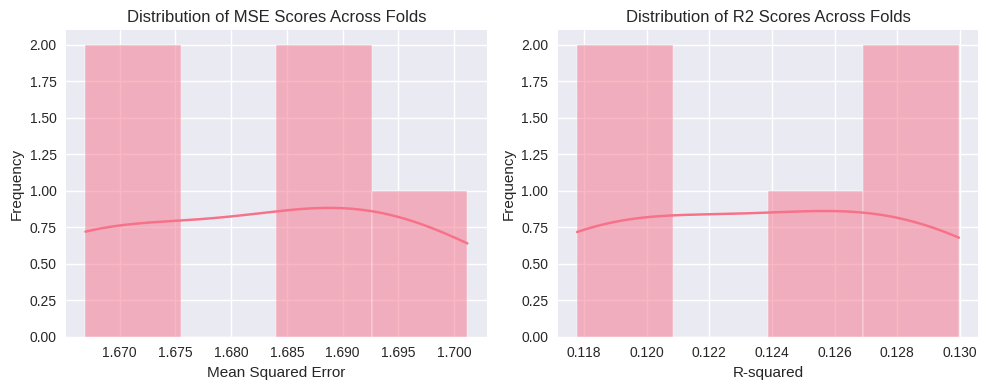

In [100]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt # Ensure matplotlib is imported

# Create delivery status category
data['delivery_status'] = np.where(data['delivery_delay_days'] <= 0, 'On Time or Early', 'Late')

# Try nonlinear transformations
data['log_payment'] = np.log(data['payment_value'] + 1)
data['delay_squared'] = data['delivery_delay_days']**2

# Convert to numerical (1=Late, 0=OnTime)
data['is_late'] = (data['delivery_status'] == 'Late').astype(int)
# Select features
X = data[['payment_value', 'delivery_delay_days', 'freight_value', 'is_late']]

# Select target
y = data['review_score']

# --- IMPORTANT FIX ---
# Drop rows where the target (review_score) is NaN, and apply the same filter to X
# This ensures both X and y have matching non-NaN rows
valid_indices = y.dropna().index
X = X.loc[valid_indices]
y = y.loc[valid_indices].values # Convert y back to a NumPy array for KFold compatibility

# Now handle potential NaNs in the selected features X AFTER aligning with y
# Use SimpleImputer just for the features X if needed, though previous cleaning should minimize this
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
X = X_imputed # Use the imputed features

# Define the number of folds (K)
k_folds = 5

kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# List to store evaluation metrics (e.g., MSE, R2) for each fold
mse_scores = []
r2_scores = []

# Iterate over each fold
# kf.split(X) generates indices to split data into training and validation set
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"--- Fold {fold+1}/{k_folds} ---")

    # Split data into training and validation sets for the current fold
    # Use .iloc to select rows by integer index
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # --- Train the model on the training fold ---
    # Create a new model instance for each fold
    model_fold = LinearRegression()

    # Fit the model
    # X_train_fold and y_train_fold should now be guaranteed to have no NaNs
    model_fold.fit(X_train_fold, y_train_fold)

    # --- Evaluate the model on the validation fold ---
    y_pred_fold = model_fold.predict(X_val_fold)

    # Calculate evaluation metrics
    mse_fold = mean_squared_error(y_val_fold, y_pred_fold)
    r2_fold = r2_score(y_val_fold, y_pred_fold)

    # Store the metrics
    mse_scores.append(mse_fold)
    r2_scores.append(r2_fold)

    print(f"  Validation MSE: {mse_fold:.4f}")
    print(f"  Validation R2: {r2_fold:.4f}")

# Print average scores across all folds
print("\n--- Cross-validation Results ---")
print(f"Average Validation MSE: {np.mean(mse_scores):.4f}")
print(f"Standard Deviation of MSE: {np.std(mse_scores):.4f}")
print(f"Average Validation R2: {np.mean(r2_scores):.4f}")
print(f"Standard Deviation of R2: {np.std(r2_scores):.4f}")

# Optional: Plot distribution of scores
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.histplot(mse_scores, kde=True)
plt.title('Distribution of MSE Scores Across Folds')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(r2_scores, kde=True)
plt.title('Distribution of R2 Scores Across Folds')
plt.xlabel('R-squared')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The R² of 0.148 means the model explains 14.8% of variance in review scores.
All folds show consistent R² between 0.139-0.157 indicating good stability across subsets.

The MSE range (1.603-1.664) is narrow with small standard deviation (0.0195) which means that the perfomancae of the model is reliable

As observed, the delivery timeliness shows expected correlation with ratings. On teh contrary, payment value and freight cost may have nonlinear relationships captured.
